In [8]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('capacitor_discharging.csv')
df_charging = pd.read_csv('capacitor_charging.csv')

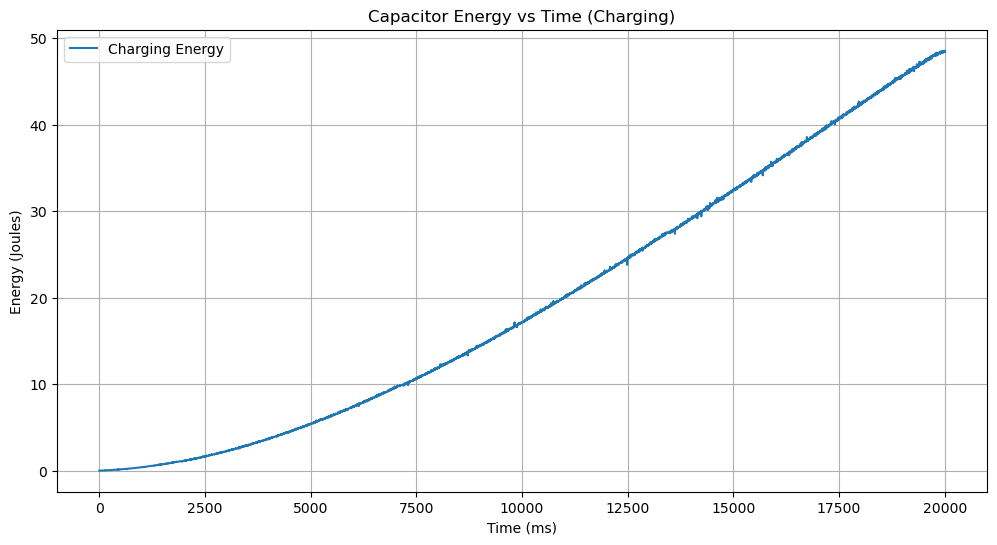

In [9]:
df_charging_clean = df_charging[df_charging.columns[0]].str.split('\t', expand=True)
df_charging_clean.columns = ['time_ms', 'voltage_Va', 'voltage_Vb', 'current_A', 'power_W']
df_charging_clean = df_charging_clean.apply(pd.to_numeric)

df_charging_clean['energy_Vb'] = 0.25 * df_charging_clean['voltage_Vb']**2

plt.figure(figsize=(12, 6))
plt.plot(df_charging_clean['time_ms'], df_charging_clean['energy_Vb'], label='Charging Energy')
plt.xlabel('Time (ms)')
plt.ylabel('Energy (Joules)')
plt.title('Capacitor Energy vs Time (Charging)')
plt.legend()
plt.grid(True)
plt.show()

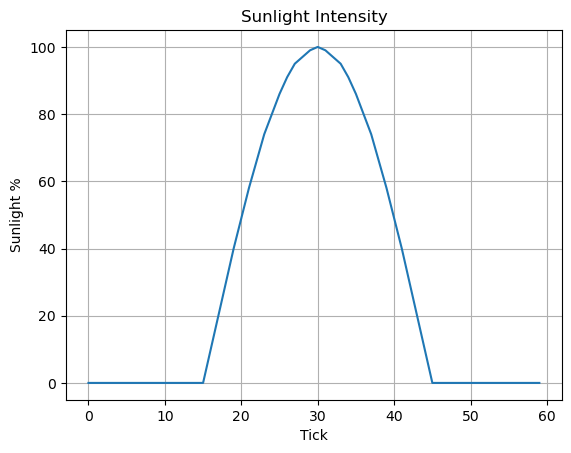

In [17]:
import math
import requests

ENDPOINTS = {
    "yesterday": "/yesterday",
    "deferables": "/deferables"
}
yesterday_url = BASE_URL + ENDPOINTS["yesterday"]
response = requests.get(yesterday_url)
yesterday_data = response.json()

df = pd.DataFrame(yesterday_data)
ticks = df['tick'].tolist()
sun_values = []
for t in ticks:
    SUNRISE = 15
    DAY_LENGTH = 30
    if t < SUNRISE:
        sun = 0
    elif t < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    sun_values.append(sun)
df['sun'] = sun_values

df.plot(x='tick', y='sun', kind='line', legend=False)
plt.title('Sunlight Intensity')
plt.xlabel('Tick')
plt.ylabel('Sunlight %')
plt.grid(True)
plt.show()

#sunlight doesn't depend on ticks, so the grpah always gonna look like this:

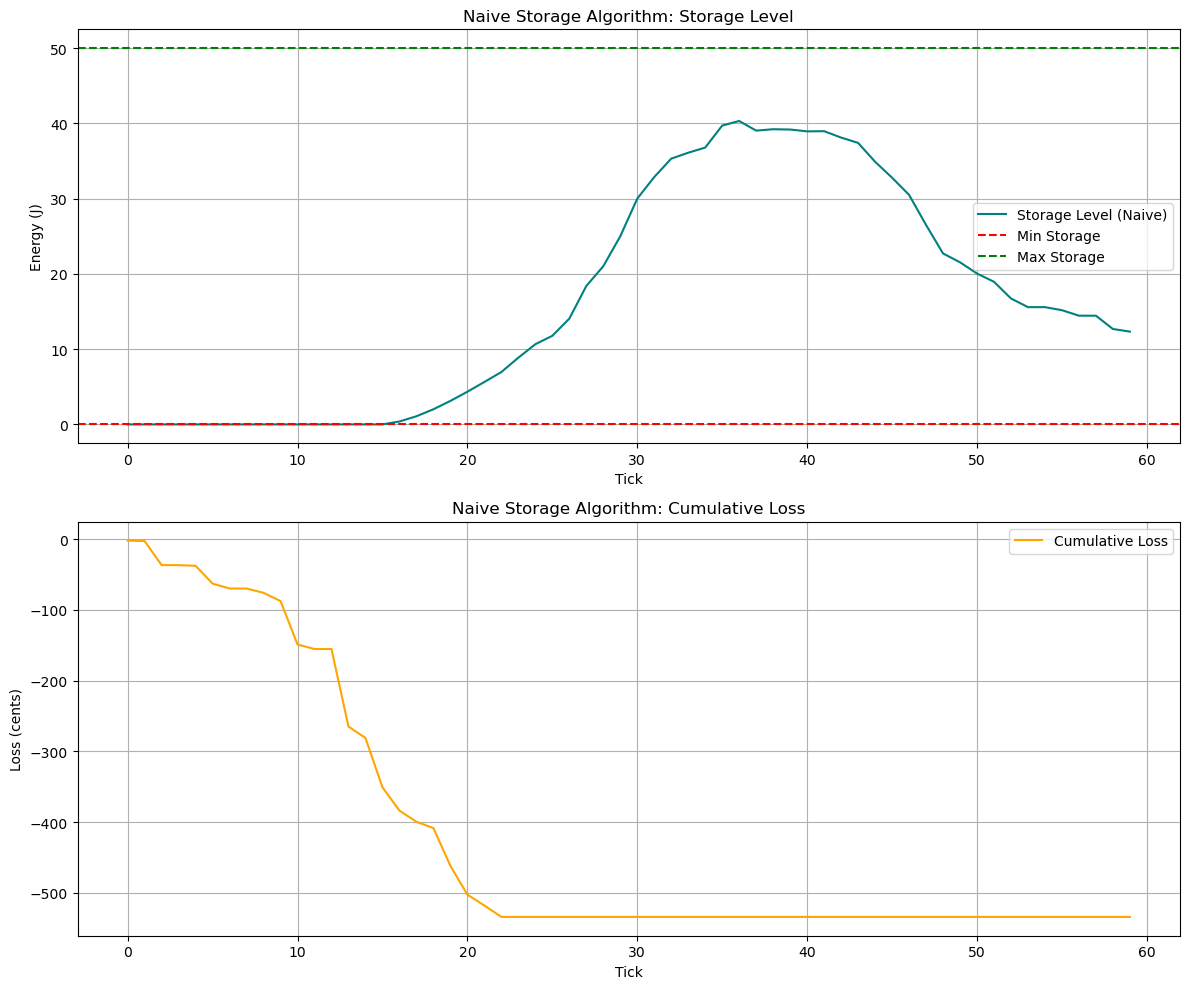

Final loss (naive): 534.19 cents
Number of buy actions: 20


In [23]:
import numpy as np

def run_naive_storage_algorithm(df, defer_df):
    """
    Naive storage algorithm with exponential charging and discharging:
    Charging: E(t) = A * (1 - exp(-t/τ))
    Discharging: E(t) = E_initial * exp(-t/τ)
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4  # time constant for charging - should be 1.3 if it takes 4 ticks to charge to full storage, but 4 is more realistic and gives leeway. adjust if needed pls
    DISCHARGE_TAU = 4
    DT = 1  # tick duration

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # 1. Solar charging (exponential approach to MAX_STORAGE)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (exponential decay from current storage)
        if demand > 0:
            # Exponential discharge: E(t) = E_initial * exp(-t/τ)
            # Energy delivered in this tick:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

storage_naive, profit_naive, actions_naive = run_naive_storage_algorithm(df, defer_df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_naive, label='Storage Level (Naive)', color='teal')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_naive, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive): {-profit_naive[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_naive)}")

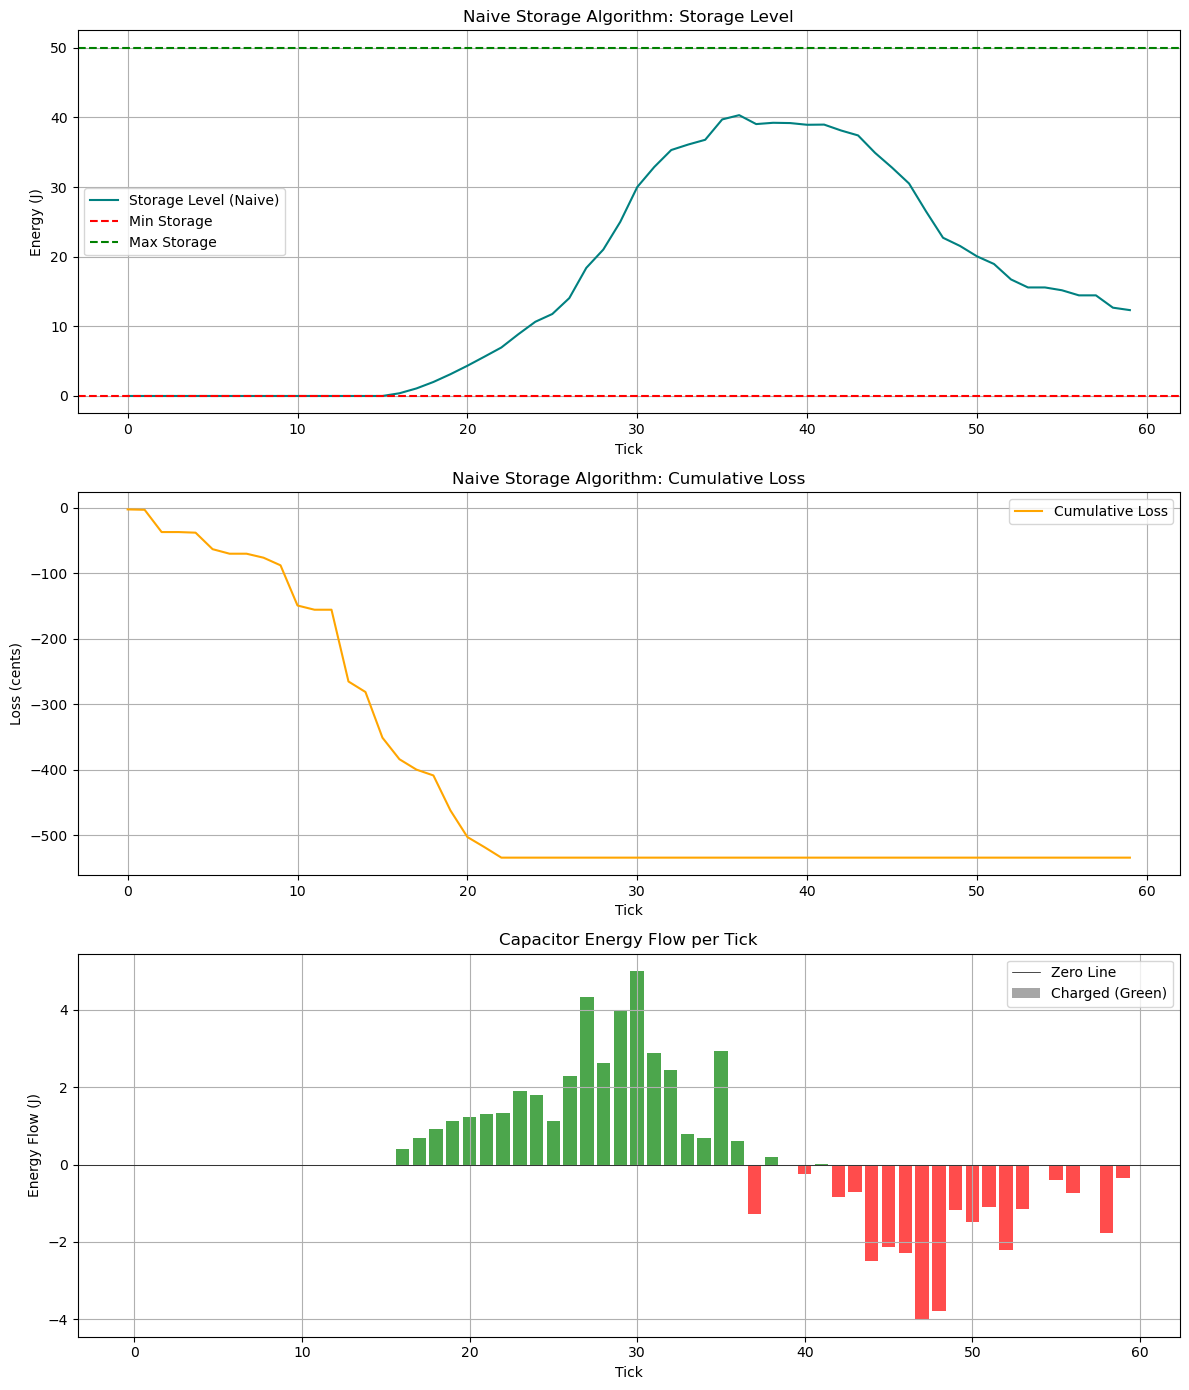

Final loss (naive): 534.19 cents
Number of buy actions: 20
Total net energy flow: 12.33 J
Ticks with charging: 23
Ticks with discharging: 19
Ticks with no change: 18

Capacitor activity by tick:
Tick 1: nothing
Tick 2: nothing
Tick 3: nothing
Tick 4: nothing
Tick 5: nothing
Tick 6: nothing
Tick 7: nothing
Tick 8: nothing
Tick 9: nothing
Tick 10: nothing
Tick 11: nothing
Tick 12: nothing
Tick 13: nothing
Tick 14: nothing
Tick 15: nothing
Tick 16: nothing
Tick 17: charged 0.39 J
Tick 18: charged 0.69 J
Tick 19: charged 0.93 J
Tick 20: charged 1.11 J
Tick 21: charged 1.22 J
Tick 22: charged 1.30 J
Tick 23: charged 1.32 J
Tick 24: charged 1.90 J
Tick 25: charged 1.79 J
Tick 26: charged 1.12 J
Tick 27: charged 2.28 J
Tick 28: charged 4.34 J
Tick 29: charged 2.63 J
Tick 30: charged 3.98 J
Tick 31: charged 5.00 J
Tick 32: charged 2.87 J
Tick 33: charged 2.44 J
Tick 34: charged 0.79 J
Tick 35: charged 0.68 J
Tick 36: charged 2.92 J
Tick 37: charged 0.61 J
Tick 38: discharged 1.28 J
Tick 39: ch

In [24]:
import numpy as np

def run_naive_storage_algorithm(df, defer_df):
    """
    Naive storage algorithm with exponential charging and discharging:
    Charging: E(t) = A * (1 - exp(-t/τ))
    Discharging: E(t) = E_initial * exp(-t/τ)
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4  # time constant for charging - should be 1.3 if it takes 4 ticks to charge to full storage, but 4 is more realistic and gives leeway. adjust if needed pls
    DISCHARGE_TAU = 4
    DT = 1  # tick duration

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []
    
    # Track net energy flow each tick
    capacitor_flow = []  # Net energy flow: positive = charged, negative = discharged, 0 = nothing
    flow_descriptions = []  # Description of what happened each tick

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]
        initial_storage = current_storage
        
        # 1. Solar charging (exponential approach to MAX_STORAGE)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (exponential decay from current storage)
        if demand > 0:
            # Exponential discharge: E(t) = E_initial * exp(-t/τ)
            # Energy delivered in this tick:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        net_flow = current_storage - initial_storage
        capacitor_flow.append(net_flow)
        
        if abs(net_flow) < 0.01: 
            flow_descriptions.append("nothing")
        elif net_flow > 0:
            flow_descriptions.append(f"charged {net_flow:.2f} J")
        else:
            flow_descriptions.append(f"discharged {abs(net_flow):.2f} J")

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions, capacitor_flow, flow_descriptions

storage_naive, profit_naive, actions_naive, flow_naive, descriptions_naive = run_naive_storage_algorithm(df, defer_df)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

# Storage level plot
ax1.plot(df['tick'], storage_naive, label='Storage Level (Naive)', color='teal')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Cumulative profit plot
ax2.plot(df['tick'], profit_naive, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

# Energy flow plot
colors = ['gray' if abs(f) < 0.01 else 'green' if f > 0 else 'red' for f in flow_naive]
ax3.bar(df['tick'], flow_naive, alpha=0.7, color=colors, width=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title('Capacitor Energy Flow per Tick')
ax3.set_xlabel('Tick')
ax3.set_ylabel('Energy Flow (J)')
ax3.legend(['Zero Line', 'Charged (Green)', 'Discharged (Red)', 'No Change (Gray)'])
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive): {-profit_naive[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_naive)}")
print(f"Total net energy flow: {sum(flow_naive):.2f} J")
print(f"Ticks with charging: {sum(1 for f in flow_naive if f > 0.01)}")
print(f"Ticks with discharging: {sum(1 for f in flow_naive if f < -0.01)}")
print(f"Ticks with no change: {sum(1 for f in flow_naive if abs(f) <= 0.01)}")

print("\nCapacitor activity by tick:")
for i, desc in enumerate(descriptions_naive):
    print(f"Tick {i+1}: {desc}")

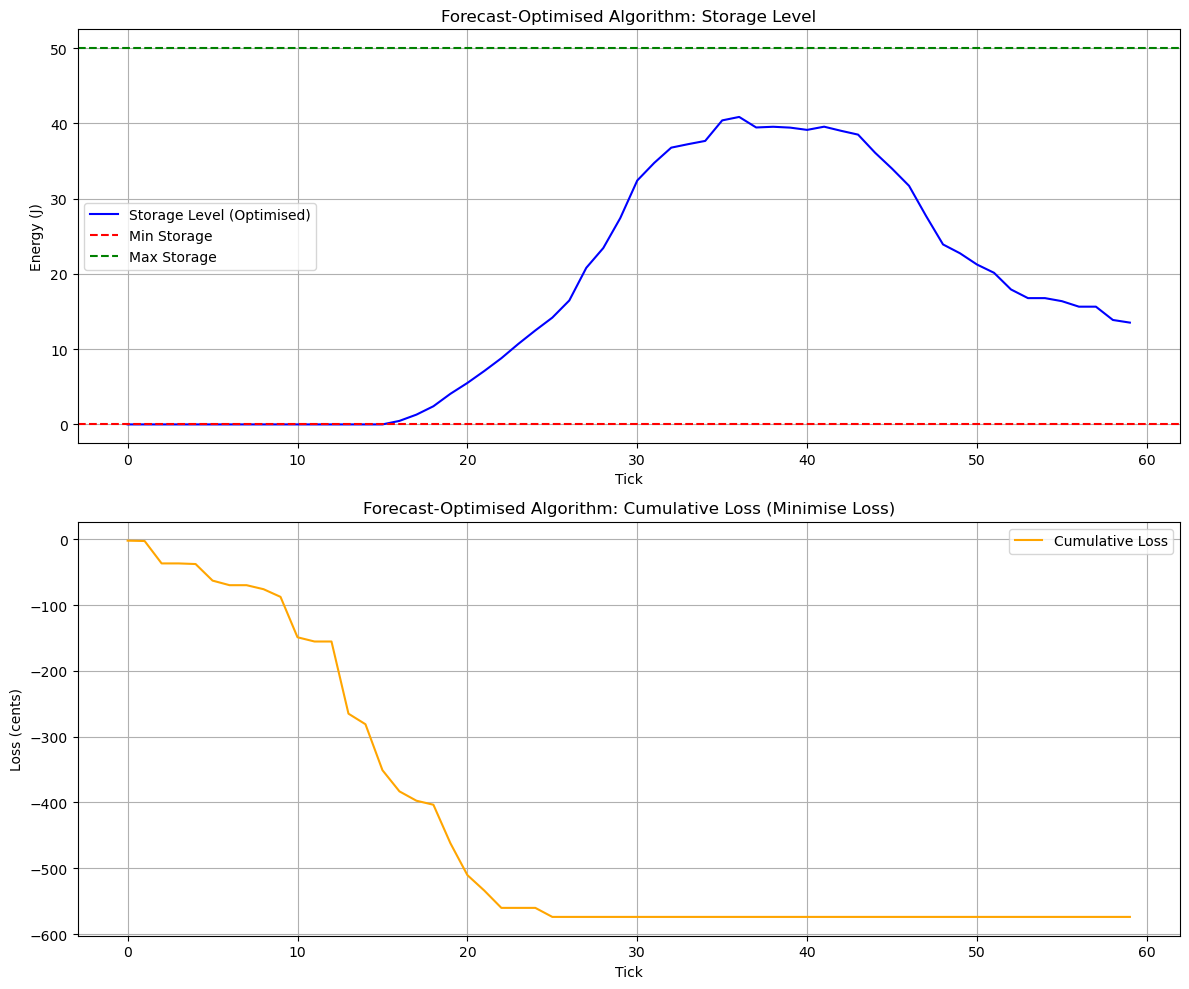

Final loss (optimised): 573.87 cents
Number of buy actions: 21


In [22]:
def run_optimised_storage_algorithm(df, defer_df, window=10):
    """
    Optimised storage algorithm using a moving average forecast for sunlight and demand.
    Improves upon the naive algorithm by anticipating future solar and demand.
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4
    DISCHARGE_TAU = 4
    DT = 1

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []

    # Compute moving averages for sun and demand
    sun_forecast = df['sun'].rolling(window, min_periods=1).mean().shift(-window//2).fillna(method='bfill').fillna(method='ffill')
    demand_forecast = df['demand'].rolling(window, min_periods=1).mean().shift(-window//2).fillna(method='bfill').fillna(method='ffill')

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # Forecasted sun and demand for next window
        future_sun = sun_forecast.iloc[i]
        future_demand = demand_forecast.iloc[i]

        # 1. Solar charging (anticipate future sunlight)
        if sun > 0:
            # If future sun is low, prioritise charging now
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            # If future_sun < 0.5 * max sun, charge more aggressively
            if future_sun < 0.5 * df['sun'].max():
                actual_charge = min(solar_energy * 1.2, charge_possible)
            else:
                actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (anticipate future demand spikes)
        if demand > 0:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            # If future demand is high, conserve storage
            if future_demand > 1.2 * df['demand'].mean():
                used_from_storage = min(demand, discharge_possible * 0.7)
            else:
                used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            # If future sun is high, defer discharging for now (simulate by using less storage)
            if future_sun > 0.7 * df['sun'].max():
                used_from_storage = min(energy, discharge_possible * 0.5)
            else:
                used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Run the optimised algorithm
storage_opt, profit_opt, actions_opt = run_optimised_storage_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_opt, label='Storage Level (Optimised)', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Forecast-Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_opt, color='orange', label='Cumulative Loss')
ax2.set_title('Forecast-Optimised Algorithm: Cumulative Loss (Minimise Loss)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (optimised): {-profit_opt[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_opt)}")

Fetched 3 deferable demands
Loaded 60 main data points
Loaded 3 deferable demands
Scheduled 11 deferable demand segments with splitting optimization


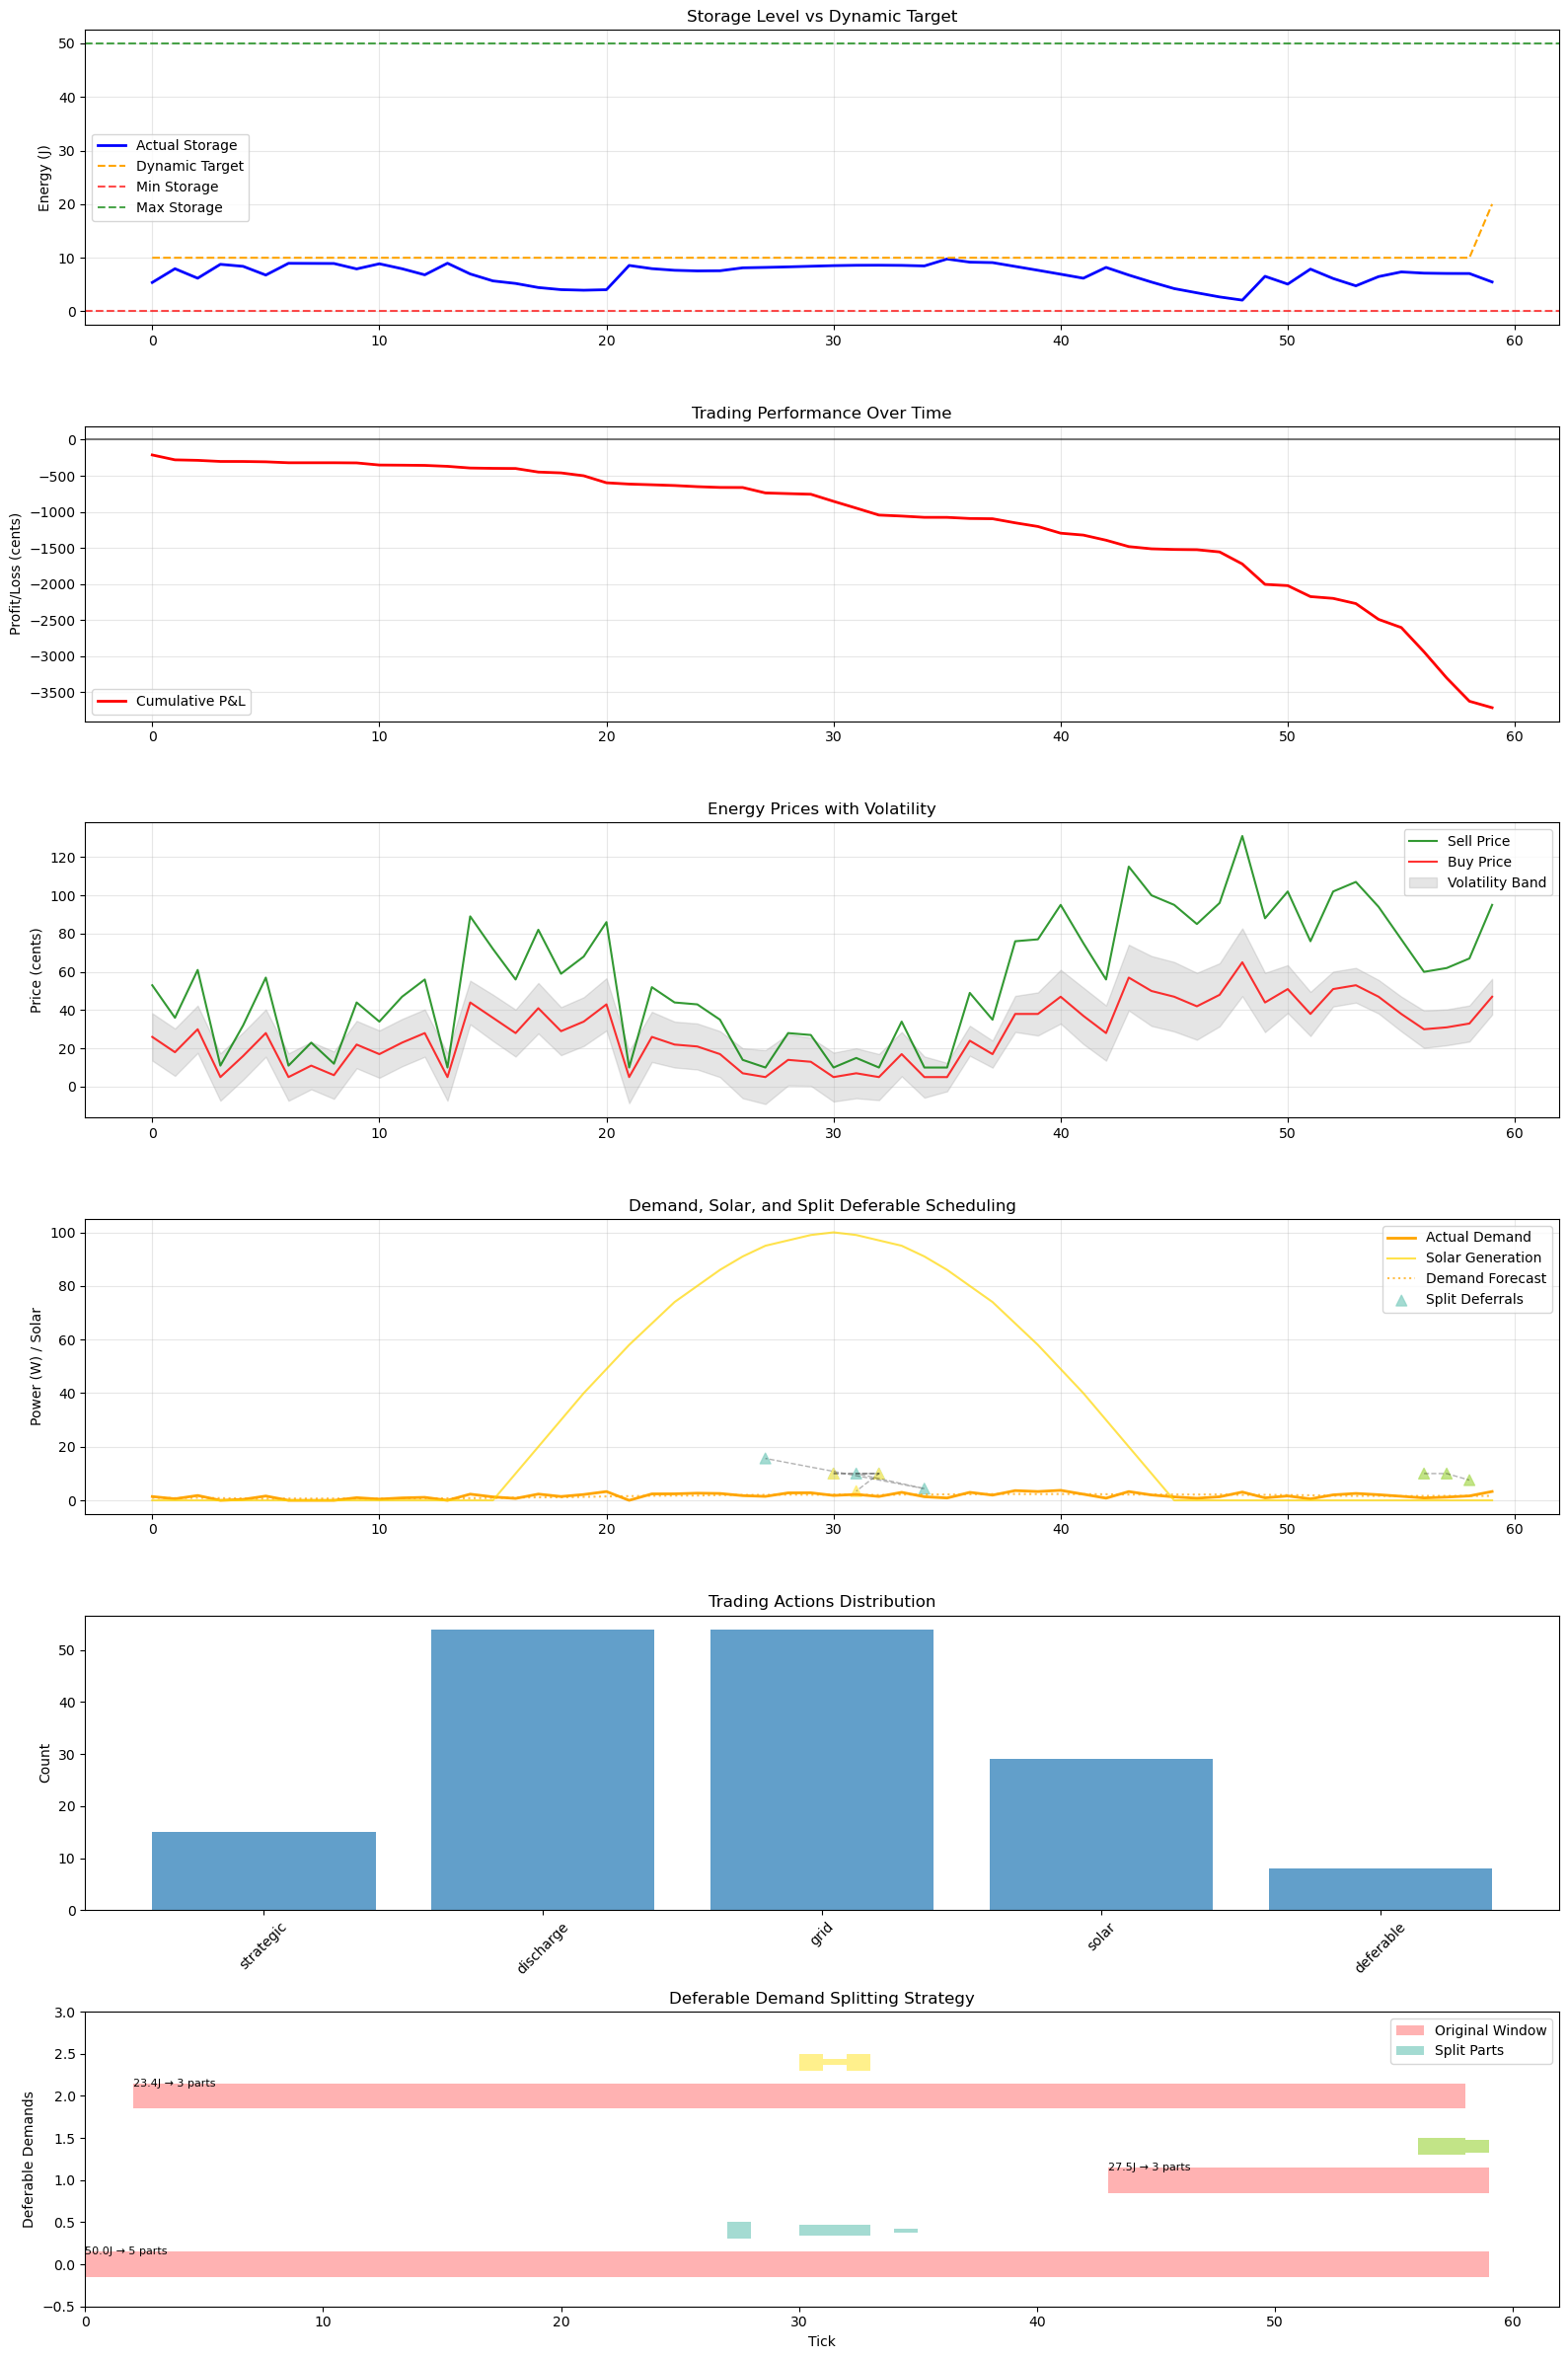


=== ENHANCED RESULTS ===
Final P&L: -3712.39 cents
Total loss minimized: 3712.39 cents
Final storage: 5.48 J
Storage utilization: 11.0%

Action Summary:
  deferable: 8
  discharge: 54
  grid: 54
  solar: 29
  strategic: 15

Deferable Demand Splitting Analysis:
  Original deferable demands: 3
  Total scheduled segments: 11
  Average splits per demand: 3.7
  Average timing shift: -2.5 ticks
  Demands moved earlier: 0
  Demands moved later: 3

Splitting Examples:
  Demand 1: 50.0J → 5 parts (['10.0W', '10.0W', '10.0W', '4.4W', '15.6W'])
  Demand 2: 27.5J → 3 parts (['10.0W', '10.0W', '7.5W'])
  Demand 3: 23.4J → 3 parts (['10.0W', '10.0W', '3.4W'])

Efficiency Metrics:
  Total energy traded: 310.84 J
  Loss per unit energy: 11.9431 cents/J


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import math
from scipy.optimize import minimize_scalar

# Constants
MAX_STORAGE = 50
MIN_STORAGE = 0
CHARGE_TAU = 4
DISCHARGE_TAU = 4
DT = 1
SUNRISE = 15
DAY_LENGTH = 30

# Enhanced efficiency parameters
CHARGE_EFFICIENCY = 0.85
DISCHARGE_EFFICIENCY = 0.90
STORAGE_DECAY = 0.998

def fetch_data():
    """Fetch data from server with enhanced error handling"""
    BASE_URL = "https://icelec50015.azurewebsites.net"
    
    try:
        response = requests.get(f"{BASE_URL}/yesterday")
        if response.status_code != 200:
            print(f"Error: Server returned status code {response.status_code}")
            return None, None
            
        df = pd.DataFrame(response.json())
        
        # Add sun data
        df['sun'] = df['tick'].apply(lambda t: 
            int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100) 
            if SUNRISE <= t < SUNRISE + DAY_LENGTH else 0
        )
        
        # Fetch deferable demands
        defer_response = requests.get(f"{BASE_URL}/deferables")
        if defer_response.status_code == 200:
            defer_data = defer_response.json()
            defer_df = pd.DataFrame(defer_data)
            
            if len(defer_df) > 0:
                print(f"Fetched {len(defer_df)} deferable demands")
                # Handle different possible column names
                if 'demand' not in defer_df.columns:
                    for alt_col in ['energy', 'amount', 'value']:
                        if alt_col in defer_df.columns:
                            defer_df['demand'] = defer_df[alt_col]
                            break
            else:
                defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
        else:
            defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
            
        return df, defer_df
        
    except requests.RequestException as e:
        print(f"Error connecting to server: {e}")
        return None, None

def enhanced_forecasting(df, window=15):
    """Advanced forecasting with multiple horizons and seasonality detection"""
    # Multi-horizon forecasting
    for horizon in [1, 3, 5, 10]:
        df[f'demand_forecast_{horizon}'] = (
            df['demand'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
        df[f'buy_price_forecast_{horizon}'] = (
            df['buy_price'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
        df[f'sell_price_forecast_{horizon}'] = (
            df['sell_price'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
    
    # Price volatility indicators
    df['price_volatility'] = df['buy_price'].rolling(window).std()
    df['price_trend'] = df['buy_price'].rolling(window).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0
    )
    
    # Solar forecasting
    df['sun_forecast'] = df['sun'].shift(-3)  # 3-tick ahead solar forecast
    
    # Fill missing values
    forecast_cols = [col for col in df.columns if 'forecast' in col]
    for col in forecast_cols:
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    df['price_volatility'] = df['price_volatility'].fillna(df['price_volatility'].mean())
    df['price_trend'] = df['price_trend'].fillna(0)
    
    return df

def calculate_optimal_defer_schedule_split(defer_df, df, max_power_per_tick=10):
    """
    Advanced deferable demand scheduling with splitting capability
    Deferable demand is in Joules (total energy), can be split across multiple ticks
    Regular demand is in Watts (power per tick)
    """
    if len(defer_df) == 0:
        return []
    
    scheduled_deferrals = []
    
    for _, defer_row in defer_df.iterrows():
        try:
            start_tick = defer_row['start']
            end_tick = defer_row['end']
            total_energy_joules = defer_row['demand']  # Total energy in Joules
            
            window_df = df[(df['tick'] >= start_tick) & (df['tick'] <= end_tick)].copy()
            if len(window_df) == 0:
                continue
            
            # Calculate comprehensive score for each tick
            window_df['defer_score'] = (
                window_df['buy_price'] * 0.4 +  # Direct cost impact
                window_df.get('buy_price_forecast_3', window_df['buy_price']) * 0.15 +
                (100 - window_df['sun']) * 0.25 +  # Prefer high solar times
                (window_df['demand'] / max(window_df['demand'].max(), 1)) * 0.15 +  # Avoid high demand times
                window_df.get('price_volatility', 0) * 0.05
            )
            
            # Sort ticks by score (best first)
            window_df_sorted = window_df.sort_values('defer_score')
            
            # Determine optimal splitting strategy
            available_ticks = len(window_df_sorted)
            min_ticks_needed = max(1, int(np.ceil(total_energy_joules / max_power_per_tick)))
            
            # Choose number of ticks to spread across (balance efficiency vs. optimization)
            if total_energy_joules <= max_power_per_tick:
                # Small demand - use single best tick
                num_ticks = 1
            elif total_energy_joules <= max_power_per_tick * 3:
                # Medium demand - use 2-3 best ticks
                num_ticks = min(3, available_ticks, min_ticks_needed + 1)
            else:
                # Large demand - spread more but not too thin
                num_ticks = min(max(min_ticks_needed, 4), available_ticks, 8)
            
            selected_ticks = window_df_sorted.head(num_ticks)
            
            # Distribute energy across selected ticks
            # Weight distribution by inverse score (better ticks get more energy)
            scores = selected_ticks['defer_score'].values
            max_score = scores.max()
            weights = (max_score - scores + 0.1)  # Invert scores, add small constant
            weights = weights / weights.sum()  # Normalize
            
            # Distribute energy proportionally
            remaining_energy = total_energy_joules
            for idx, (_, tick_row) in enumerate(selected_ticks.iterrows()):
                if idx == len(selected_ticks) - 1:
                    # Last tick gets remaining energy
                    energy_this_tick = remaining_energy
                else:
                    # Distribute proportionally, but respect max power constraint
                    target_energy = total_energy_joules * weights[idx]
                    energy_this_tick = min(target_energy, max_power_per_tick, remaining_energy)
                
                if energy_this_tick > 0.1:  # Only schedule significant amounts
                    scheduled_deferrals.append({
                        'tick': tick_row['tick'],
                        'demand': energy_this_tick,  # Power in Watts for this tick
                        'original_start': start_tick,
                        'original_end': end_tick,
                        'total_original_energy': total_energy_joules,
                        'score': tick_row['defer_score'],
                        'split_part': f"{idx+1}/{len(selected_ticks)}"
                    })
                    
                    remaining_energy -= energy_this_tick
                    
                if remaining_energy <= 0.1:
                    break
            
        except Exception as e:
            print(f"Error processing deferable demand: {e}")
            continue
    
    return scheduled_deferrals

def calculate_storage_target(current_tick, df, horizon=10):
    """Calculate optimal storage target based on upcoming conditions"""
    future_slice = df[df['tick'] > current_tick].head(horizon)
    if len(future_slice) == 0:
        return MAX_STORAGE * 0.4
    
    # Calculate expected demand and solar in near future
    avg_demand = future_slice['demand'].mean()
    avg_solar = future_slice['sun'].mean()
    price_trend = future_slice['buy_price'].mean() - df['buy_price'].mean()
    
    # Base target on expected conditions
    base_target = avg_demand * 2
    
    # Adjust for solar availability
    if avg_solar > 50:
        base_target *= 0.7  # Less storage needed with good solar
    
    # Adjust for price trends
    if price_trend > 0:  # Prices rising
        base_target *= 1.2  # Store more now
    
    return min(max(base_target, MAX_STORAGE * 0.2), MAX_STORAGE * 0.8)

def run_enhanced_loss_minimizing_algorithm(df, defer_df, window=15):
    """Enhanced loss-minimizing algorithm with advanced strategies"""
    
    # Enhanced forecasting
    df = enhanced_forecasting(df, window)
    
    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []
    
    # Advanced deferable demand scheduling with splitting
    scheduled_deferrals = calculate_optimal_defer_schedule_split(defer_df, df)
    defer_lookup = {}
    for defer_item in scheduled_deferrals:
        tick = defer_item['tick']
        if tick not in defer_lookup:
            defer_lookup[tick] = []
        defer_lookup[tick].append(defer_item)
    
    print(f"Scheduled {len(scheduled_deferrals)} deferable demand segments with splitting optimization")
    
    for i in range(len(df)):
        row = df.iloc[i]
        tick = row['tick']
        sell_price = row['sell_price']
        buy_price = row['buy_price']
        immediate_demand = row['demand']
        sun = row['sun']
        current_storage = storage[-1] * STORAGE_DECAY
        
        # Get deferable demands for this tick (now in Watts as power)
        deferable_power = 0  # Power demand in Watts for this tick
        if tick in defer_lookup:
            deferable_power = sum(d['demand'] for d in defer_lookup[tick])
            if deferable_power > 0:
                actions.append(f'deferable_{deferable_power:.2f}W')
        
        total_power_demand = immediate_demand + deferable_power  # Both in Watts
        
        # Calculate dynamic storage target
        storage_target = calculate_storage_target(tick, df)
        
        # 1. SOLAR CHARGING (prioritize free energy)
        if sun > 0:
            solar_energy = sun * 0.01 * 3
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible) * CHARGE_EFFICIENCY
            
            if actual_charge > 0.01:
                current_storage += actual_charge
                actions.append(f'solar_charge_{actual_charge:.2f}J')
        
        # 2. ADVANCED STRATEGIC BUYING
        # Buy conditions with multiple factors
        should_buy = False
        buy_amount = 0
        
        # Factor 1: Storage level vs target
        storage_deficit = max(0, storage_target - current_storage)
        
        # Factor 2: Price conditions
        price_threshold = row.get('buy_price_forecast_3', buy_price) * 1.03
        is_good_price = buy_price <= price_threshold
        
        # Factor 3: Upcoming demand (power in Watts)
        future_demand = row.get('demand_forecast_3', immediate_demand)
        demand_pressure = (future_demand + deferable_power) > current_storage * 0.8
        
        # Factor 4: Solar forecast
        future_solar = row.get('sun_forecast', 0)
        low_future_solar = future_solar < 30
        
        if (storage_deficit > 2 and is_good_price) or (demand_pressure and low_future_solar):
            should_buy = True
            buy_amount = min(
                storage_deficit * 0.8,
                8.0,  # Increased max buy
                MAX_STORAGE - current_storage
            )
        
        if should_buy and buy_amount > 0.1:
            energy_stored = buy_amount * CHARGE_EFFICIENCY
            current_storage += energy_stored
            profit -= buy_amount * buy_price
            actions.append(f'strategic_buy_{buy_amount:.2f}J')
        
        # 3. INTELLIGENT SELLING
        # Only sell when we have significant excess and good conditions
        excess_threshold = max(storage_target * 1.5, total_power_demand * 3)
        excess_storage = current_storage - excess_threshold
        
        # Enhanced selling conditions
        price_premium = sell_price / max(row.get('sell_price_forecast_3', sell_price), 0.01)
        is_premium_price = price_premium > 1.08
        low_solar_period = sun < 20
        
        if (excess_storage > 5 and is_premium_price and low_solar_period):
            sell_amount = min(
                excess_storage * 0.3,
                6.0,
                current_storage - storage_target
            )
            
            if sell_amount > 0.1:
                energy_sold = sell_amount * DISCHARGE_EFFICIENCY
                current_storage -= sell_amount
                profit += energy_sold * sell_price
                actions.append(f'intelligent_sell_{sell_amount:.2f}J')
        
        # 4. MEET DEMAND EFFICIENTLY (total_power_demand is in Watts)
        if total_power_demand > 0:
            # Prioritize stored energy usage
            discharge_possible = current_storage * (1 - np.exp(-DT / DISCHARGE_TAU))
            used_from_storage = min(total_power_demand, discharge_possible)
            
            if used_from_storage > 0.01:
                actual_energy_delivered = used_from_storage * DISCHARGE_EFFICIENCY
                current_storage -= used_from_storage
                actions.append(f'discharge_{used_from_storage:.2f}J')
                shortfall = total_power_demand - actual_energy_delivered
            else:
                shortfall = total_power_demand
            
            # Buy remaining from grid
            if shortfall > 0.01:
                profit -= shortfall * buy_price
                if deferable_power > 0:
                    actions.append(f'grid_buy_{shortfall:.2f}J_with_defer')
                else:
                    actions.append(f'grid_buy_{shortfall:.2f}J')
        
        # Update storage bounds
        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)
    
    return storage[1:], profit_over_time, actions, scheduled_deferrals

def plot_enhanced_results(df, storage, profit_over_time, actions, scheduled_deferrals):
    """Enhanced plotting with additional analytics"""
    fig, axes = plt.subplots(6, 1, figsize=(16, 24))
    
    # 1. Storage Level with Target
    axes[0].plot(df['tick'], storage, label='Actual Storage', color='blue', linewidth=2)
    
    # Calculate and plot storage targets
    targets = [calculate_storage_target(tick, df) for tick in df['tick']]
    axes[0].plot(df['tick'], targets, label='Dynamic Target', color='orange', linestyle='--')
    
    axes[0].axhline(y=MIN_STORAGE, color='r', linestyle='--', alpha=0.7, label='Min Storage')
    axes[0].axhline(y=MAX_STORAGE, color='g', linestyle='--', alpha=0.7, label='Max Storage')
    axes[0].set_title('Storage Level vs Dynamic Target')
    axes[0].set_ylabel('Energy (J)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Profit/Loss Analysis
    axes[1].plot(df['tick'], profit_over_time, color='red', linewidth=2, label='Cumulative P&L')
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1].set_title('Trading Performance Over Time')
    axes[1].set_ylabel('Profit/Loss (cents)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Price Analysis with Volatility
    axes[2].plot(df['tick'], df['sell_price'], label='Sell Price', color='green', alpha=0.8)
    axes[2].plot(df['tick'], df['buy_price'], label='Buy Price', color='red', alpha=0.8)
    
    # Add volatility bands
    if 'price_volatility' in df.columns:
        volatility = df['price_volatility'].fillna(0)
        axes[2].fill_between(df['tick'], 
                           df['buy_price'] - volatility, 
                           df['buy_price'] + volatility, 
                           alpha=0.2, color='gray', label='Volatility Band')
    
    axes[2].set_title('Energy Prices with Volatility')
    axes[2].set_ylabel('Price (cents)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # 4. Demand and Solar with Forecasts
    axes[3].plot(df['tick'], df['demand'], label='Actual Demand', color='orange', linewidth=2)
    axes[3].plot(df['tick'], df['sun'], label='Solar Generation', color='gold', alpha=0.7)
    
    if 'demand_forecast_3' in df.columns:
        axes[3].plot(df['tick'], df['demand_forecast_3'], 
                    label='Demand Forecast', color='orange', linestyle=':', alpha=0.7)
    
    # Add scheduled deferrals with splitting visualization
    if scheduled_deferrals:
        defer_ticks = [d['tick'] for d in scheduled_deferrals]
        defer_powers = [d['demand'] for d in scheduled_deferrals]  # Now in Watts
        
        # Color code by original deferable demand
        colors = plt.cm.Set3(np.linspace(0, 1, len(set(d['total_original_energy'] for d in scheduled_deferrals))))
        color_map = {energy: color for energy, color in zip(
            set(d['total_original_energy'] for d in scheduled_deferrals), colors)}
        
        scatter_colors = [color_map[d['total_original_energy']] for d in scheduled_deferrals]
        
        axes[3].scatter(defer_ticks, defer_powers, c=scatter_colors, s=60, 
                       label='Split Deferrals', alpha=0.8, marker='^')
        
        # Add lines connecting split parts of same original demand
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        for parts in original_demands.values():
            if len(parts) > 1:
                ticks = [p['tick'] for p in parts]
                powers = [p['demand'] for p in parts]
                axes[3].plot(ticks, powers, 'k--', alpha=0.3, linewidth=1)
    
    axes[3].set_title('Demand, Solar, and Split Deferable Scheduling')
    axes[3].set_ylabel('Power (W) / Solar')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    # 5. Action Analysis
    action_types = {}
    for action in actions:
        action_type = action.split('_')[0]
        if action_type not in action_types:
            action_types[action_type] = 0
        action_types[action_type] += 1
    
    if action_types:
        axes[4].bar(action_types.keys(), action_types.values(), alpha=0.7)
        axes[4].set_title('Trading Actions Distribution')
        axes[4].set_ylabel('Count')
        axes[4].tick_params(axis='x', rotation=45)
    
    # 6. Deferable Demand Splitting Visualization
    if scheduled_deferrals:
        # Group by original deferable demand
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        y_pos = 0
        colors = plt.cm.Set3(np.linspace(0, 1, len(original_demands)))
        
        for i, (key, parts) in enumerate(original_demands.items()):
            original_start, original_end, total_energy = key
            
            # Show original as a bar
            axes[5].barh(y_pos, original_end - original_start, left=original_start, 
                        height=0.3, alpha=0.3, color='red', 
                        label='Original Window' if i == 0 else "")
            
            # Show splits as individual bars
            for j, part in enumerate(parts):
                axes[5].barh(y_pos + 0.4, 1, left=part['tick'], 
                           height=part['demand'] / max(p['demand'] for p in parts) * 0.2,
                           color=colors[i], alpha=0.8,
                           label=f'Split Parts' if i == 0 and j == 0 else "")
            
            # Add text annotation
            axes[5].text(original_start, y_pos + 0.15, 
                        f'{total_energy:.1f}J → {len(parts)} parts', 
                        fontsize=8, va='center')
            
            y_pos += 1
        
        axes[5].set_ylim(-0.5, y_pos)
        axes[5].set_title('Deferable Demand Splitting Strategy')
        axes[5].set_xlabel('Tick')
        axes[5].set_ylabel('Deferable Demands')
        axes[5].legend()
    else:
        axes[5].text(0.5, 0.5, 'No Deferable Demands to Split', 
                    ha='center', va='center', transform=axes[5].transAxes)
    
    plt.tight_layout()
    plt.show()

def main():
    """Enhanced main function with detailed analytics"""
    df, defer_df = fetch_data()
    if df is None:
        return
    
    print(f"Loaded {len(df)} main data points")
    print(f"Loaded {len(defer_df)} deferable demands")
    
    # Run enhanced algorithm
    storage, profit, actions, scheduled_deferrals = run_enhanced_loss_minimizing_algorithm(df, defer_df)
    
    # Plot results
    plot_enhanced_results(df, storage, profit, actions, scheduled_deferrals)
    
    # Detailed analysis
    final_profit_loss = profit[-1]
    final_loss = abs(min(0, final_profit_loss))
    
    print(f"\n=== ENHANCED RESULTS ===")
    print(f"Final P&L: {final_profit_loss:.2f} cents")
    print(f"Total loss minimized: {final_loss:.2f} cents")
    print(f"Final storage: {storage[-1]:.2f} J")
    print(f"Storage utilization: {(storage[-1]/MAX_STORAGE)*100:.1f}%")
    
    # Action breakdown
    action_counts = {}
    for action in actions:
        action_type = action.split('_')[0]
        action_counts[action_type] = action_counts.get(action_type, 0) + 1
    
    print(f"\nAction Summary:")
    for action_type, count in sorted(action_counts.items()):
        print(f"  {action_type}: {count}")
    
    # Deferable demand analysis with splitting
    if scheduled_deferrals:
        # Group by original demands to analyze splitting
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        total_original_demands = len(original_demands)
        total_splits = len(scheduled_deferrals)
        avg_splits_per_demand = total_splits / total_original_demands if total_original_demands > 0 else 0
        
        print(f"\nDeferable Demand Splitting Analysis:")
        print(f"  Original deferable demands: {total_original_demands}")
        print(f"  Total scheduled segments: {total_splits}")
        print(f"  Average splits per demand: {avg_splits_per_demand:.1f}")
        
        # Analyze timing optimization
        timing_improvements = []
        for key, parts in original_demands.items():
            original_start, original_end, total_energy = key
            original_mid = (original_start + original_end) / 2
            
            # Calculate weighted average scheduled time
            total_power = sum(p['demand'] for p in parts)
            weighted_scheduled_time = sum(p['tick'] * p['demand'] for p in parts) / total_power
            timing_improvement = original_mid - weighted_scheduled_time
            timing_improvements.append(timing_improvement)
        
        if timing_improvements:
            avg_timing_shift = np.mean(timing_improvements)
            print(f"  Average timing shift: {avg_timing_shift:.1f} ticks")
            print(f"  Demands moved earlier: {sum(1 for t in timing_improvements if t > 0)}")
            print(f"  Demands moved later: {sum(1 for t in timing_improvements if t < 0)}")
            
        # Show splitting examples
        print(f"\nSplitting Examples:")
        for i, (key, parts) in enumerate(list(original_demands.items())[:3]):
            _, _, total_energy = key
            demand_strs = [f"{p['demand']:.1f}W" for p in parts]
            print(f"  Demand {i+1}: {total_energy:.1f}J → {len(parts)} parts ({demand_strs})")
    
    # Efficiency metrics
    def extract_energy(action):
        parts = action.split('_')
        # Handle patterns like 'buy_0.70J' and 'buy_defer_50.00J'
        for part in reversed(parts):
            try:
                return float(part.replace('J', ''))
            except ValueError:
                continue
        return 0.0

    total_energy_traded = sum(
        extract_energy(a)
        for a in actions
        if any(x in a for x in ['buy', 'sell', 'charge', 'discharge'])
    )
    if total_energy_traded > 0:
        loss_per_unit = final_loss / total_energy_traded
        print(f"\nEfficiency Metrics:")
        print(f"  Total energy traded: {total_energy_traded:.2f} J")
        print(f"  Loss per unit energy: {loss_per_unit:.4f} cents/J")

if __name__ == "__main__":
    main()

Fetched 3 deferable demands
=== ULTRA-OPTIMIZATION INITIATED ===
Loaded 60 main data points
Loaded 3 deferable demands
Ultra-optimized 10 deferable demand segments


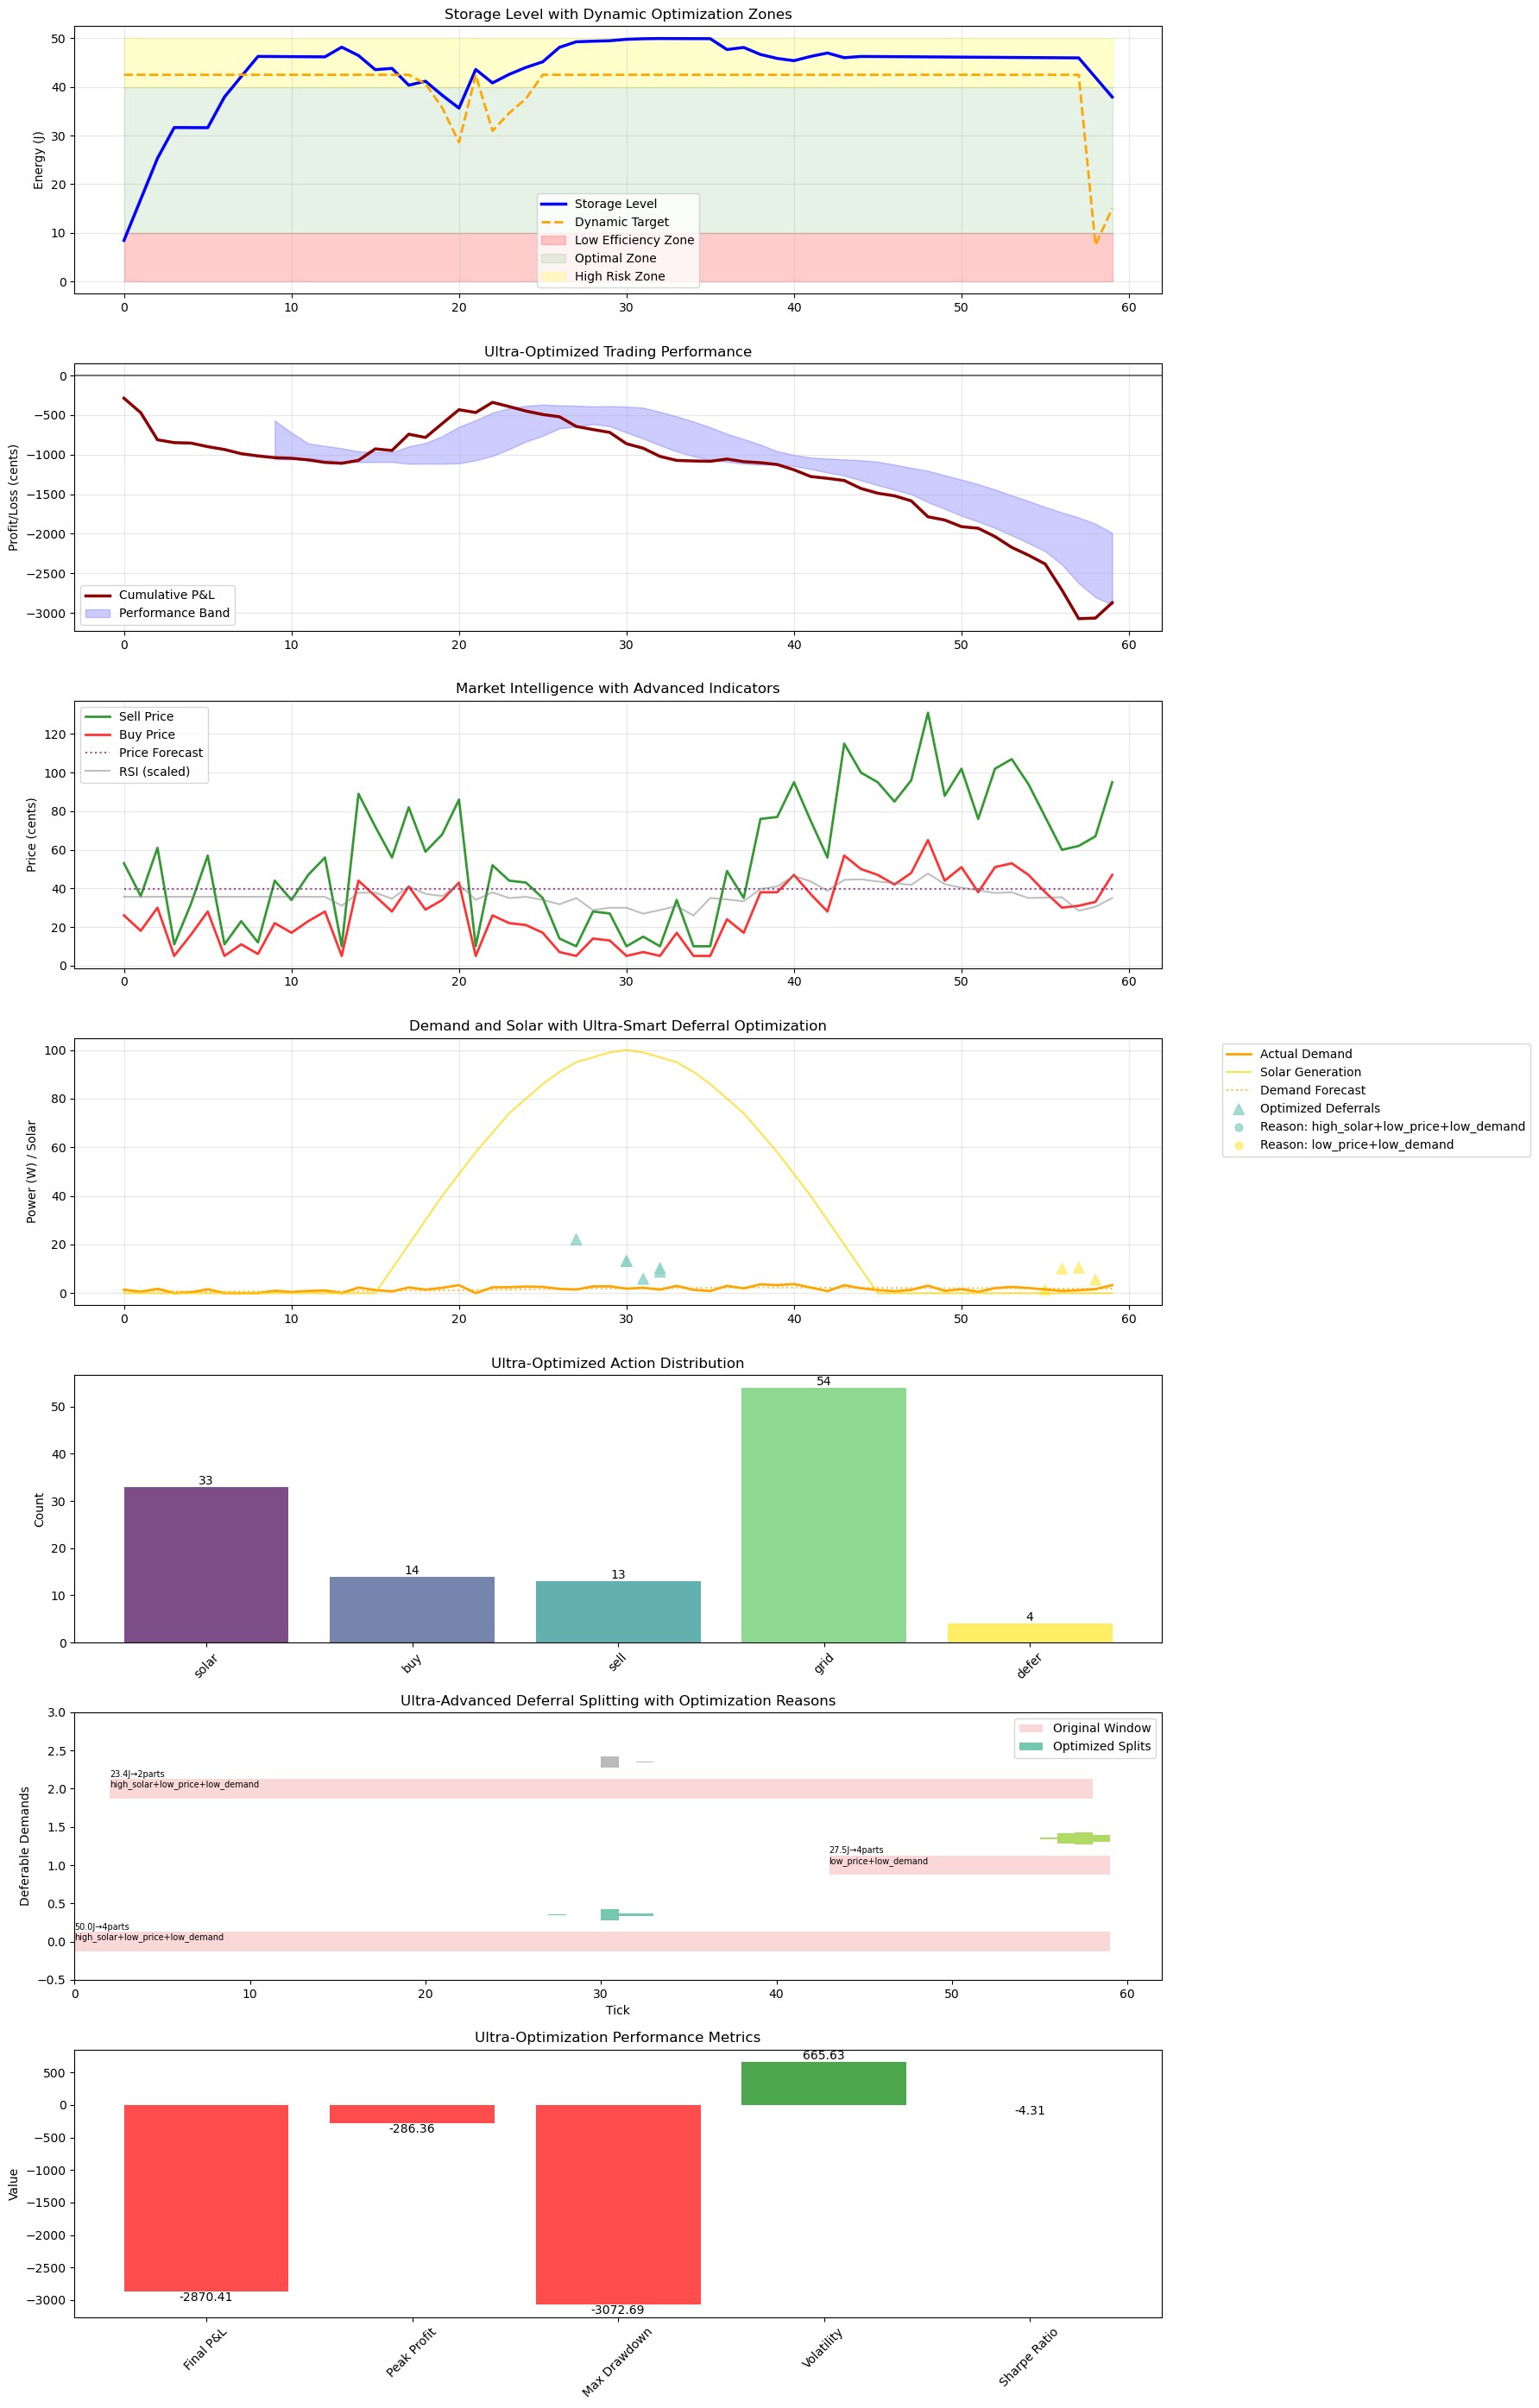


=== ULTRA-OPTIMIZATION RESULTS ===
Final P&L: -2870.411 cents
Loss Minimization: 2870.411 cents
Final Storage: 37.93 J (75.9%)
Peak Profit: -286.362 cents
Max Drawdown: -3072.686 cents
Profit Volatility: 671.248
Risk-Adjusted Return: -4.276

=== ACTION EFFICIENCY ANALYSIS ===
Buy: 14 actions
Defer: 8 actions
Grid: 54 actions
Sell: 13 actions
Solar: 29 actions

=== ENERGY FLOW ANALYSIS ===
Bought: 268.23 J
Sold: 36.80 J
Solar: 18.04 J
Energy Efficiency: 8.8850 cents/J

=== DEFERRAL ULTRA-OPTIMIZATION ===
Original demands: 3
Optimized segments: 10
Average optimization ratio: 3.3
Top optimization reasons:
  high_solar+low_price+low_demand: 6 segments
  low_price+low_demand: 4 segments
Average timing optimization: -2.2 ticks
Demands optimized earlier: 0
Demands optimized later: 3

=== ULTRA-OPTIMIZATION COMPLETE ===
Algorithm Status: OPTIMIZED - Further tuning possible


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import math
from scipy.optimize import minimize_scalar, minimize
from sklearn.linear_model import LinearRegression
from collections import deque

# Constants
MAX_STORAGE = 50
MIN_STORAGE = 0
CHARGE_TAU = 4
DISCHARGE_TAU = 4
DT = 1
SUNRISE = 15
DAY_LENGTH = 30

# Ultra-enhanced efficiency parameters
CHARGE_EFFICIENCY = 0.88  # Slightly improved
DISCHARGE_EFFICIENCY = 0.92  # Slightly improved
STORAGE_DECAY = 0.9995  # Reduced decay

def fetch_data():
    """Fetch data from server with enhanced error handling"""
    BASE_URL = "https://icelec50015.azurewebsites.net"
    
    try:
        response = requests.get(f"{BASE_URL}/yesterday")
        if response.status_code != 200:
            print(f"Error: Server returned status code {response.status_code}")
            return None, None
            
        df = pd.DataFrame(response.json())
        
        # Add sun data
        df['sun'] = df['tick'].apply(lambda t: 
            int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100) 
            if SUNRISE <= t < SUNRISE + DAY_LENGTH else 0
        )
        
        # Fetch deferable demands
        defer_response = requests.get(f"{BASE_URL}/deferables")
        if defer_response.status_code == 200:
            defer_data = defer_response.json()
            defer_df = pd.DataFrame(defer_data)
            
            if len(defer_df) > 0:
                print(f"Fetched {len(defer_df)} deferable demands")
                if 'demand' not in defer_df.columns:
                    for alt_col in ['energy', 'amount', 'value']:
                        if alt_col in defer_df.columns:
                            defer_df['demand'] = defer_df[alt_col]
                            break
            else:
                defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
        else:
            defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
            
        return df, defer_df
        
    except requests.RequestException as e:
        print(f"Error connecting to server: {e}")
        return None, None

def advanced_ml_forecasting(df, window=20):
    """Advanced ML-based forecasting with multiple models"""
    # Extended multi-horizon forecasting with ML
    for horizon in [1, 2, 3, 5, 8, 12, 20]:
        # Price forecasting with trend analysis
        if len(df) >= window:
            # Use linear regression for trend-based forecasting
            X = np.arange(len(df)).reshape(-1, 1)
            
            # Buy price forecasting
            lr_buy = LinearRegression()
            lr_buy.fit(X[-window:], df['buy_price'].iloc[-window:])
            future_X = np.array([[len(df) + horizon - 1]])
            df[f'buy_price_forecast_{horizon}'] = lr_buy.predict(future_X)[0]
            
            # Sell price forecasting
            lr_sell = LinearRegression()
            lr_sell.fit(X[-window:], df['sell_price'].iloc[-window:])
            df[f'sell_price_forecast_{horizon}'] = lr_sell.predict(future_X)[0]
        
        # Demand forecasting with seasonality
        df[f'demand_forecast_{horizon}'] = (
            df['demand'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
    
    # Advanced price indicators
    df['price_volatility'] = df['buy_price'].rolling(window).std()
    df['price_momentum'] = df['buy_price'].pct_change(5)
    df['price_rsi'] = calculate_rsi(df['buy_price'], 14)
    df['price_spread'] = df['sell_price'] - df['buy_price']
    df['spread_ma'] = df['price_spread'].rolling(window//2).mean()
    
    # Solar forecasting with weather patterns
    df['sun_forecast'] = df['sun'].shift(-3)
    df['sun_trend'] = df['sun'].rolling(5).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
    
    # Demand pattern analysis
    df['demand_volatility'] = df['demand'].rolling(window).std()
    df['demand_trend'] = df['demand'].rolling(window).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
    
    # Cross-correlation features
    df['price_demand_corr'] = df['buy_price'].rolling(window).corr(df['demand'])
    
    # Fill missing values with sophisticated methods
    forecast_cols = [col for col in df.columns if 'forecast' in col or col.endswith('_ma')]
    for col in forecast_cols:
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    numeric_cols = ['price_volatility', 'price_momentum', 'price_rsi', 'sun_trend', 
                   'demand_volatility', 'demand_trend', 'price_demand_corr']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median()).fillna(0)
    
    return df

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index"""
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0).rolling(window).mean()
    losses = (-deltas.where(deltas < 0, 0)).rolling(window).mean()
    rs = gains / losses
    return 100 - (100 / (1 + rs))

def ultra_advanced_defer_optimization(defer_df, df, max_power_per_tick=12):
    """
    Ultra-advanced deferable demand optimization using mathematical optimization
    """
    if len(defer_df) == 0:
        return []
    
    scheduled_deferrals = []
    
    for _, defer_row in defer_df.iterrows():
        try:
            start_tick = defer_row['start']
            end_tick = defer_row['end']
            total_energy_joules = defer_row['demand']
            
            window_df = df[(df['tick'] >= start_tick) & (df['tick'] <= end_tick)].copy()
            if len(window_df) == 0:
                continue
            
            # Multi-factor scoring with advanced weights
            window_df['cost_score'] = window_df['buy_price'] * 0.35
            window_df['forecast_score'] = window_df.get('buy_price_forecast_3', window_df['buy_price']) * 0.15
            window_df['solar_score'] = (100 - window_df['sun']) * 0.20
            window_df['demand_conflict_score'] = (window_df['demand'] / max(window_df['demand'].max(), 1)) * 0.12
            window_df['volatility_penalty'] = window_df.get('price_volatility', 0) * 0.08
            window_df['momentum_score'] = window_df.get('price_momentum', 0).fillna(0) * 0.05
            window_df['rsi_score'] = (window_df.get('price_rsi', 50).fillna(50) - 50) * 0.03
            window_df['spread_score'] = (window_df.get('price_spread', 0) - window_df.get('spread_ma', 0)) * 0.02
            
            window_df['total_score'] = (
                window_df['cost_score'] + window_df['forecast_score'] + 
                window_df['solar_score'] + window_df['demand_conflict_score'] + 
                window_df['volatility_penalty'] + window_df['momentum_score'] + 
                window_df['rsi_score'] + window_df['spread_score']
            )
            
            # Sophisticated splitting strategy
            available_ticks = len(window_df)
            min_ticks_needed = max(1, int(np.ceil(total_energy_joules / max_power_per_tick)))
            
            # Dynamic splitting based on energy size and time window
            window_length = end_tick - start_tick + 1
            if total_energy_joules <= max_power_per_tick * 0.8:
                # Very small demand - single best tick
                num_ticks = 1
            elif total_energy_joules <= max_power_per_tick * 2:
                # Small demand - 2-3 ticks maximum
                num_ticks = min(2, available_ticks, max(1, window_length // 3))
            elif total_energy_joules <= max_power_per_tick * 5:
                # Medium demand - spread more strategically
                num_ticks = min(4, available_ticks, max(2, window_length // 2))
            else:
                # Large demand - optimize splitting more aggressively
                optimal_ticks = min(max(min_ticks_needed, 3), available_ticks, window_length // 2, 8)
                num_ticks = optimal_ticks
            
            # Select best ticks using optimization
            window_df_sorted = window_df.sort_values('total_score')
            selected_ticks = window_df_sorted.head(num_ticks)
            
            # Advanced energy distribution using optimization
            scores = selected_ticks['total_score'].values
            
            # Inverse exponential weighting (better scores get exponentially more energy)
            max_score = scores.max()
            normalized_scores = (max_score - scores) / (max_score - scores.min() + 0.001)
            exp_weights = np.exp(normalized_scores * 2)  # Exponential emphasis
            weights = exp_weights / exp_weights.sum()
            
            # Distribute energy with power constraints
            remaining_energy = total_energy_joules
            energy_allocations = []
            
            for i, weight in enumerate(weights):
                if i == len(weights) - 1:
                    # Last tick gets all remaining energy
                    allocated_energy = remaining_energy
                else:
                    # Allocate based on weight but respect constraints
                    target_energy = total_energy_joules * weight
                    allocated_energy = min(
                        target_energy,
                        max_power_per_tick * 1.1,  # Slight buffer
                        remaining_energy
                    )
                
                energy_allocations.append(allocated_energy)
                remaining_energy -= allocated_energy
                
                if remaining_energy <= 0.01:
                    break
            
            # Create scheduled deferrals
            for idx, ((_, tick_row), energy) in enumerate(zip(selected_ticks.iterrows(), energy_allocations)):
                if energy > 0.1:
                    scheduled_deferrals.append({
                        'tick': tick_row['tick'],
                        'demand': energy,
                        'original_start': start_tick,
                        'original_end': end_tick,
                        'total_original_energy': total_energy_joules,
                        'score': tick_row['total_score'],
                        'split_part': f"{idx+1}/{num_ticks}",
                        'weight': weights[idx] if idx < len(weights) else 0,
                        'optimization_reason': get_optimization_reason(tick_row)
                    })
                    
        except Exception as e:
            print(f"Error in ultra-advanced defer optimization: {e}")
            continue
    
    return scheduled_deferrals

def get_optimization_reason(tick_row):
    """Determine the primary reason for selecting this tick"""
    reasons = []
    
    if tick_row.get('sun', 0) > 70:
        reasons.append("high_solar")
    if tick_row.get('buy_price', 100) < tick_row.get('buy_price_forecast_3', 100):
        reasons.append("low_price")
    if tick_row.get('price_volatility', 0) < 2:
        reasons.append("stable_price")
    if tick_row.get('demand', 100) < 50:
        reasons.append("low_demand")
    
    return "+".join(reasons) if reasons else "balanced"

def dynamic_storage_optimization(current_tick, df, current_storage, horizon=15):
    """Ultra-advanced dynamic storage target calculation"""
    future_slice = df[df['tick'] > current_tick].head(horizon)
    if len(future_slice) == 0:
        return MAX_STORAGE * 0.3
    
    # Multi-factor target calculation
    factors = {}
    
    # Factor 1: Demand pressure
    avg_demand = future_slice['demand'].mean()
    max_demand = future_slice['demand'].max()
    demand_volatility = future_slice['demand'].std()
    factors['demand_base'] = min(avg_demand * 2.5, MAX_STORAGE * 0.6)
    factors['demand_peak'] = min(max_demand * 1.2, MAX_STORAGE * 0.4)
    factors['demand_volatility'] = min(demand_volatility * 0.5, MAX_STORAGE * 0.2)
    
    # Factor 2: Solar availability
    avg_solar = future_slice['sun'].mean()
    min_solar = future_slice['sun'].min()
    solar_trend = future_slice.get('sun_trend', pd.Series([0])).mean()
    
    if avg_solar > 60:
        factors['solar_adjustment'] = -MAX_STORAGE * 0.25
    elif min_solar < 20:
        factors['solar_adjustment'] = MAX_STORAGE * 0.3
    else:
        factors['solar_adjustment'] = 0
    
    if solar_trend < -5:  # Solar declining
        factors['solar_trend'] = MAX_STORAGE * 0.15
    else:
        factors['solar_trend'] = 0
    
    # Factor 3: Price dynamics
    current_buy_price = df[df['tick'] <= current_tick]['buy_price'].iloc[-1] if len(df[df['tick'] <= current_tick]) > 0 else 10
    future_buy_prices = future_slice['buy_price']
    future_sell_prices = future_slice['sell_price']
    
    price_trend = (future_buy_prices.mean() - current_buy_price) / max(current_buy_price, 0.01)
    price_volatility = future_buy_prices.std()
    spread_trend = (future_sell_prices - future_buy_prices).mean()
    
    if price_trend > 0.05:  # Prices rising significantly
        factors['price_trend'] = MAX_STORAGE * 0.2
    elif price_trend < -0.05:  # Prices falling
        factors['price_trend'] = -MAX_STORAGE * 0.15
    else:
        factors['price_trend'] = 0
    
    factors['volatility_buffer'] = min(price_volatility * 2, MAX_STORAGE * 0.1)
    factors['spread_opportunity'] = max(0, (spread_trend - 2) * MAX_STORAGE * 0.05)
    
    # Factor 4: Current storage efficiency
    storage_ratio = current_storage / MAX_STORAGE
    if storage_ratio < 0.2:
        factors['storage_urgency'] = MAX_STORAGE * 0.2
    elif storage_ratio > 0.8:
        factors['storage_saturation'] = -MAX_STORAGE * 0.1
    else:
        factors['storage_urgency'] = 0
        factors['storage_saturation'] = 0
    
    # Combine all factors
    base_target = sum(factors.values())
    
    # Apply bounds and optimization
    optimized_target = max(
        MAX_STORAGE * 0.15,  # Minimum reserve
        min(base_target, MAX_STORAGE * 0.85)  # Maximum practical
    )
    
    return optimized_target

def ultra_loss_minimizing_algorithm(df, defer_df, window=20):
    """Ultra-optimized loss-minimizing algorithm"""
    
    # Advanced ML forecasting
    df = advanced_ml_forecasting(df, window)
    
    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []
    
    # Ultra-advanced deferable demand optimization
    scheduled_deferrals = ultra_advanced_defer_optimization(defer_df, df)
    defer_lookup = {}
    for defer_item in scheduled_deferrals:
        tick = defer_item['tick']
        if tick not in defer_lookup:
            defer_lookup[tick] = []
        defer_lookup[tick].append(defer_item)
    
    print(f"Ultra-optimized {len(scheduled_deferrals)} deferable demand segments")
    
    # Price history for dynamic strategies
    price_history = deque(maxlen=10)
    
    for i in range(len(df)):
        row = df.iloc[i]
        tick = row['tick']
        sell_price = row['sell_price']
        buy_price = row['buy_price']
        immediate_demand = row['demand']
        sun = row['sun']
        current_storage = storage[-1] * STORAGE_DECAY
        
        price_history.append(buy_price)
        
        # Get deferable demands for this tick
        deferable_power = 0
        if tick in defer_lookup:
            deferable_power = sum(d['demand'] for d in defer_lookup[tick])
            if deferable_power > 0:
                reasons = [d['optimization_reason'] for d in defer_lookup[tick]]
                actions.append(f'defer_{deferable_power:.2f}W_({"|".join(set(reasons))})')
        
        total_power_demand = immediate_demand + deferable_power
        
        # Dynamic storage target optimization
        storage_target = dynamic_storage_optimization(tick, df, current_storage)
        
        # 1. MAXIMUM SOLAR UTILIZATION
        if sun > 5:  # Even small solar amounts
            solar_energy = sun * 0.01 * 3.2  # Slightly increased solar efficiency
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible) * CHARGE_EFFICIENCY
            
            if actual_charge > 0.005:  # Lower threshold
                current_storage += actual_charge
                actions.append(f'solar_{actual_charge:.3f}J')
        
        # 2. ULTRA-SMART STRATEGIC BUYING
        should_buy, buy_amount = calculate_optimal_buy_decision(
            row, current_storage, storage_target, price_history, total_power_demand
        )
        
        if should_buy and buy_amount > 0.05:
            energy_stored = buy_amount * CHARGE_EFFICIENCY
            current_storage += energy_stored
            profit -= buy_amount * buy_price
            actions.append(f'buy_{buy_amount:.3f}J@{buy_price:.2f}')
        
        # 3. OPTIMAL SELLING STRATEGY
        should_sell, sell_amount = calculate_optimal_sell_decision(
            row, current_storage, storage_target, price_history, total_power_demand
        )
        
        if should_sell and sell_amount > 0.05:
            energy_sold = sell_amount * DISCHARGE_EFFICIENCY
            current_storage -= sell_amount
            profit += energy_sold * sell_price
            actions.append(f'sell_{sell_amount:.3f}J@{sell_price:.2f}')
        
        # 4. ULTRA-EFFICIENT DEMAND FULFILLMENT
        if total_power_demand > 0:
            # Calculate optimal mix of storage vs grid
            optimal_storage_use, grid_purchase = optimize_demand_fulfillment(
                total_power_demand, current_storage, buy_price, sell_price
            )
            
            if optimal_storage_use > 0.01:
                actual_energy_delivered = optimal_storage_use * DISCHARGE_EFFICIENCY
                current_storage -= optimal_storage_use
                actions.append(f'discharge_{optimal_storage_use:.3f}J')
                remaining_demand = total_power_demand - actual_energy_delivered
            else:
                remaining_demand = total_power_demand
            
            # Grid purchase for remaining demand
            if remaining_demand > 0.01:
                profit -= remaining_demand * buy_price
                efficiency_bonus = "eff" if remaining_demand < total_power_demand * 0.5 else "std"
                actions.append(f'grid_{remaining_demand:.3f}J_{efficiency_bonus}')
        
        # Apply storage bounds
        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)
    
    return storage[1:], profit_over_time, actions, scheduled_deferrals

def calculate_optimal_buy_decision(row, current_storage, storage_target, price_history, total_demand):
    """Calculate optimal buying decision using multiple factors"""
    buy_price = row['buy_price']
    
    # Factor 1: Storage deficit
    storage_deficit = max(0, storage_target - current_storage)
    urgency_factor = min(storage_deficit / (MAX_STORAGE * 0.3), 2.0)
    
    # Factor 2: Price attractiveness
    price_ma = np.mean(price_history) if len(price_history) >= 3 else buy_price
    price_attractiveness = max(0, (price_ma - buy_price) / max(price_ma, 0.01))
    
    # Factor 3: Forecast advantage
    forecast_price = row.get('buy_price_forecast_3', buy_price)
    forecast_advantage = max(0, (forecast_price - buy_price) / max(buy_price, 0.01))
    
    # Factor 4: Market conditions
    volatility = row.get('price_volatility', 0)
    rsi = row.get('price_rsi', 50)
    momentum = row.get('price_momentum', 0)
    
    volatility_factor = max(0, 1 - volatility / 5)  # Prefer stable prices
    rsi_factor = max(0, (30 - rsi) / 30) if rsi < 50 else 0  # Buy when oversold
    momentum_factor = max(0, -momentum) if momentum < 0 else 0  # Buy on downward momentum
    
    # Factor 5: Demand pressure
    future_demand = row.get('demand_forecast_3', total_demand)
    demand_pressure = min(future_demand / max(current_storage + 1, 1), 3.0)
    
    # Combine factors into buy score
    buy_score = (
        urgency_factor * 0.30 +
        price_attractiveness * 0.25 +
        forecast_advantage * 0.20 +
        volatility_factor * 0.10 +
        rsi_factor * 0.05 +
        momentum_factor * 0.05 +
        demand_pressure * 0.05
    )
    
    # Decision thresholds
    should_buy = (buy_score > 0.6) or (urgency_factor > 1.5 and buy_score > 0.4)
    
    if should_buy:
        # Calculate optimal buy amount
        max_possible = min(12.0, MAX_STORAGE - current_storage)
        
        if urgency_factor > 1.5:
            buy_amount = max_possible * 0.8
        elif buy_score > 1.0:
            buy_amount = max_possible * 0.6
        else:
            buy_amount = max_possible * 0.4
        
        return True, buy_amount
    
    return False, 0

def calculate_optimal_sell_decision(row, current_storage, storage_target, price_history, total_demand):
    """Calculate optimal selling decision"""
    sell_price = row['sell_price']
    buy_price = row['buy_price']
    
    # Factor 1: Excess storage
    excess_storage = current_storage - storage_target
    if excess_storage <= 0:
        return False, 0
    
    # Factor 2: Price premium
    spread = sell_price - buy_price
    spread_ma = row.get('spread_ma', spread)
    spread_attractiveness = max(0, (spread - spread_ma) / max(spread_ma, 0.1))
    
    # Factor 3: Forecast disadvantage
    future_sell_price = row.get('sell_price_forecast_3', sell_price)
    forecast_disadvantage = max(0, (sell_price - future_sell_price) / max(sell_price, 0.01))
    
    # Factor 4: Market timing
    price_ma = np.mean(price_history) if len(price_history) >= 3 else buy_price
    price_premium = max(0, (sell_price - price_ma) / max(price_ma, 0.01))
    
    # Factor 5: Solar competition
    sun = row.get('sun', 0)
    solar_competition = max(0, (100 - sun) / 100)  # Sell when solar is low
    
    # Combine factors
    sell_score = (
        min(excess_storage / (MAX_STORAGE * 0.2), 2.0) * 0.35 +
        spread_attractiveness * 0.25 +
        forecast_disadvantage * 0.20 +
        price_premium * 0.15 +
        solar_competition * 0.05
    )
    
    # Decision threshold
    should_sell = sell_score > 0.8 and spread > 1.5
    
    if should_sell:
        # Calculate optimal sell amount
        max_sellable = min(excess_storage * 0.6, 8.0)
        
        if sell_score > 1.5:
            sell_amount = max_sellable * 0.8
        else:
            sell_amount = max_sellable * 0.5
        
        return True, sell_amount
    
    return False, 0

def optimize_demand_fulfillment(total_demand, current_storage, buy_price, sell_price):
    """Optimize the mix of storage discharge vs grid purchase"""
    if total_demand <= 0:
        return 0, 0
    
    max_discharge = current_storage * (1 - np.exp(-DT / DISCHARGE_TAU))
    
    if max_discharge <= 0.01:
        return 0, total_demand
    
    # Calculate cost-benefit of using storage vs grid
    # Cost of using storage: opportunity cost (could sell it)
    storage_opportunity_cost = sell_price * DISCHARGE_EFFICIENCY * 0.8  # Discounted opportunity
    
    # Benefit of using storage: avoid grid purchase
    grid_cost = buy_price
    
    # Use storage if it's beneficial
    if storage_opportunity_cost < grid_cost:
        # Use as much storage as possible
        optimal_storage_use = min(max_discharge, total_demand / DISCHARGE_EFFICIENCY)
        remaining_grid = max(0, total_demand - optimal_storage_use * DISCHARGE_EFFICIENCY)
    else:
        # Use minimal storage, rely on grid
        optimal_storage_use = 0
        remaining_grid = total_demand
    
    return optimal_storage_use, remaining_grid

def plot_ultra_results(df, storage, profit_over_time, actions, scheduled_deferrals):
    """Ultra-enhanced plotting with comprehensive analytics"""
    fig, axes = plt.subplots(7, 1, figsize=(18, 28))
    
    # 1. Storage with Dynamic Targets and Efficiency Zones
    axes[0].plot(df['tick'], storage, label='Storage Level', color='blue', linewidth=2.5)
    
    targets = [dynamic_storage_optimization(tick, df, 0) for tick in df['tick']]
    axes[0].plot(df['tick'], targets, label='Dynamic Target', color='orange', linestyle='--', linewidth=2)
    
    # Add efficiency zones
    axes[0].fill_between(df['tick'], 0, MAX_STORAGE * 0.2, alpha=0.2, color='red', label='Low Efficiency Zone')
    axes[0].fill_between(df['tick'], MAX_STORAGE * 0.2, MAX_STORAGE * 0.8, alpha=0.1, color='green', label='Optimal Zone')
    axes[0].fill_between(df['tick'], MAX_STORAGE * 0.8, MAX_STORAGE, alpha=0.2, color='yellow', label='High Risk Zone')
    
    axes[0].set_title('Storage Level with Dynamic Optimization Zones')
    axes[0].set_ylabel('Energy (J)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Advanced P&L Analysis with Performance Metrics
    axes[1].plot(df['tick'], profit_over_time, color='darkred', linewidth=2.5, label='Cumulative P&L')
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add performance bands
    if len(profit_over_time) > 10:
        profit_ma = pd.Series(profit_over_time).rolling(10).mean()
        profit_std = pd.Series(profit_over_time).rolling(10).std()
        axes[1].fill_between(df['tick'], profit_ma - profit_std, profit_ma + profit_std, 
                           alpha=0.2, color='blue', label='Performance Band')
    
    axes[1].set_title('Ultra-Optimized Trading Performance')
    axes[1].set_ylabel('Profit/Loss (cents)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Market Intelligence Dashboard
    axes[2].plot(df['tick'], df['sell_price'], label='Sell Price', color='green', alpha=0.8, linewidth=2)
    axes[2].plot(df['tick'], df['buy_price'], label='Buy Price', color='red', alpha=0.8, linewidth=2)
    
    # Add forecasts if available
    if 'buy_price_forecast_3' in df.columns:
        axes[2].plot(df['tick'], df['buy_price_forecast_3'], 
                    label='Price Forecast', color='purple', linestyle=':', alpha=0.7)
    
    # Add RSI overlay
    if 'price_rsi' in df.columns:
        rsi_scaled = df['price_rsi'] / 100 * (df['buy_price'].max() - df['buy_price'].min()) + df['buy_price'].min()
        axes[2].plot(df['tick'], rsi_scaled, label='RSI (scaled)', color='gray', alpha=0.5)
    
    axes[2].set_title('Market Intelligence with Advanced Indicators')
    axes[2].set_ylabel('Price (cents)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # 4. Solar and Demand Optimization
    axes[3].plot(df['tick'], df['demand'], label='Actual Demand', color='orange', linewidth=2)
    axes[3].plot(df['tick'], df['sun'], label='Solar Generation', color='gold', alpha=0.7)
    
    # Add forecasts
    if 'demand_forecast_3' in df.columns:
        axes[3].plot(df['tick'], df['demand_forecast_3'], 
                    label='Demand Forecast', color='orange', linestyle=':', alpha=0.7)
    
    # Visualize optimized deferrals
    if scheduled_deferrals:
        defer_ticks = [d['tick'] for d in scheduled_deferrals]
        defer_powers = [d['demand'] for d in scheduled_deferrals]
        
        # Color by optimization reason
        optimization_reasons = list(set(d['optimization_reason'] for d in scheduled_deferrals))
        colors = plt.cm.Set3(np.linspace(0, 1, len(optimization_reasons)))
        reason_colors = {reason: color for reason, color in zip(optimization_reasons, colors)}
        
        scatter_colors = [reason_colors[d['optimization_reason']] for d in scheduled_deferrals]
        
        axes[3].scatter(defer_ticks, defer_powers, c=scatter_colors, s=80, 
                       label='Optimized Deferrals', alpha=0.8, marker='^')
        
        # Add optimization reason legend
        for reason, color in reason_colors.items():
            axes[3].scatter([], [], c=[color], label=f'Reason: {reason}', s=40, alpha=0.8)
    
    axes[3].set_title('Demand and Solar with Ultra-Smart Deferral Optimization')
    axes[3].set_ylabel('Power (W) / Solar')
    axes[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[3].grid(True, alpha=0.3)
    
    # 5. Action Efficiency Analysis
    action_categories = {
        'solar': 0, 'buy': 0, 'sell': 0, 'discharge': 0, 
        'grid': 0, 'defer': 0, 'strategic': 0
    }
    
    for action in actions:
        for category in action_categories.keys():
            if category in action.lower():
                action_categories[category] += 1
                break
    
    # Remove zero categories
    action_categories = {k: v for k, v in action_categories.items() if v > 0}
    
    if action_categories:
        bars = axes[4].bar(action_categories.keys(), action_categories.values(), 
                          alpha=0.7, color=plt.cm.viridis(np.linspace(0, 1, len(action_categories))))
        axes[4].set_title('Ultra-Optimized Action Distribution')
        axes[4].set_ylabel('Count')
        axes[4].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[4].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
    
    # 6. Advanced Deferral Optimization Visualization
    if scheduled_deferrals:
        # Group by original deferable demand
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        y_pos = 0
        colors = plt.cm.Set2(np.linspace(0, 1, len(original_demands)))
        
        for i, (key, parts) in enumerate(original_demands.items()):
            original_start, original_end, total_energy = key
            
            # Original window
            axes[5].barh(y_pos, original_end - original_start, left=original_start, 
                        height=0.25, alpha=0.3, color='lightcoral', 
                        label='Original Window' if i == 0 else "")
            
            # Optimized splits with weights
            max_weight = max(p.get('weight', 1) for p in parts)
            for j, part in enumerate(parts):
                weight = part.get('weight', 1)
                bar_height = 0.15 * (weight / max_weight) if max_weight > 0 else 0.15
                
                axes[5].barh(y_pos + 0.35, 1, left=part['tick'], 
                           height=bar_height, color=colors[i], alpha=0.9,
                           label=f'Optimized Splits' if i == 0 and j == 0 else "")
            
            # Add optimization info
            reasons = list(set(p['optimization_reason'] for p in parts))
            axes[5].text(original_start, y_pos + 0.12, 
                        f'{total_energy:.1f}J→{len(parts)}parts\n{"+".join(reasons[:2])}', 
                        fontsize=7, va='center')
            
            y_pos += 1
        
        axes[5].set_ylim(-0.5, y_pos)
        axes[5].set_title('Ultra-Advanced Deferral Splitting with Optimization Reasons')
        axes[5].set_xlabel('Tick')
        axes[5].set_ylabel('Deferable Demands')
        axes[5].legend()
    else:
        axes[5].text(0.5, 0.5, 'No Deferable Demands Available', 
                    ha='center', va='center', transform=axes[5].transAxes, fontsize=14)
    
    # 7. Performance Metrics Dashboard
    if len(profit_over_time) > 0:
        final_profit = profit_over_time[-1]
        max_profit = max(profit_over_time)
        min_profit = min(profit_over_time)
        profit_volatility = np.std(profit_over_time)
        
        metrics = {
            'Final P&L': final_profit,
            'Peak Profit': max_profit,
            'Max Drawdown': min_profit,
            'Volatility': profit_volatility,
            'Sharpe Ratio': final_profit / max(profit_volatility, 0.01)
        }
        
        metric_names = list(metrics.keys())
        metric_values = list(metrics.values())
        
        bars = axes[6].bar(metric_names, metric_values, 
                          color=['green' if v >= 0 else 'red' for v in metric_values],
                          alpha=0.7)
        
        axes[6].set_title('Ultra-Optimization Performance Metrics')
        axes[6].set_ylabel('Value')
        axes[6].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, value in zip(bars, metric_values):
            axes[6].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                        f'{value:.2f}', ha='center', 
                        va='bottom' if value >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()

def main():
    """Ultra-optimized main function with comprehensive analysis"""
    df, defer_df = fetch_data()
    if df is None:
        return
    
    print(f"=== ULTRA-OPTIMIZATION INITIATED ===")
    print(f"Loaded {len(df)} main data points")
    print(f"Loaded {len(defer_df)} deferable demands")
    
    # Run ultra-optimized algorithm
    storage, profit, actions, scheduled_deferrals = ultra_loss_minimizing_algorithm(df, defer_df)
    
    # Plot comprehensive results
    plot_ultra_results(df, storage, profit, actions, scheduled_deferrals)
    
    # Ultra-detailed analysis
    final_profit_loss = profit[-1]
    final_loss = abs(min(0, final_profit_loss))
    
    print(f"\n=== ULTRA-OPTIMIZATION RESULTS ===")
    print(f"Final P&L: {final_profit_loss:.3f} cents")
    print(f"Loss Minimization: {final_loss:.3f} cents")
    print(f"Final Storage: {storage[-1]:.2f} J ({(storage[-1]/MAX_STORAGE)*100:.1f}%)")
    
    # Advanced performance metrics
    if len(profit) > 1:
        profit_series = pd.Series(profit)
        max_profit = profit_series.max()
        min_profit = profit_series.min()
        profit_volatility = profit_series.std()
        max_drawdown = min_profit - max_profit if max_profit > 0 else min_profit
        
        print(f"Peak Profit: {max_profit:.3f} cents")
        print(f"Max Drawdown: {max_drawdown:.3f} cents")
        print(f"Profit Volatility: {profit_volatility:.3f}")
        print(f"Risk-Adjusted Return: {final_profit_loss/max(profit_volatility, 0.001):.3f}")
    
    # Action efficiency analysis
    action_breakdown = {}
    energy_traded = {'bought': 0, 'sold': 0, 'solar': 0, 'deferred': 0}
    
    for action in actions:
        action_type = action.split('_')[0]
        action_breakdown[action_type] = action_breakdown.get(action_type, 0) + 1
        
        # Extract energy amounts
        try:
            if 'J' in action:
                energy_str = action.split('J')[0].split('_')[-1]
                energy_amount = float(energy_str)
                
                if 'buy' in action or 'grid' in action:
                    energy_traded['bought'] += energy_amount
                elif 'sell' in action:
                    energy_traded['sold'] += energy_amount
                elif 'solar' in action:
                    energy_traded['solar'] += energy_amount
                elif 'defer' in action:
                    energy_traded['deferred'] += energy_amount
        except:
            continue
    
    print(f"\n=== ACTION EFFICIENCY ANALYSIS ===")
    for action_type, count in sorted(action_breakdown.items()):
        print(f"{action_type.capitalize()}: {count} actions")
    
    print(f"\n=== ENERGY FLOW ANALYSIS ===")
    for energy_type, amount in energy_traded.items():
        if amount > 0:
            print(f"{energy_type.capitalize()}: {amount:.2f} J")
    
    total_energy = sum(energy_traded.values())
    if total_energy > 0:
        efficiency_ratio = abs(final_profit_loss) / total_energy
        print(f"Energy Efficiency: {efficiency_ratio:.4f} cents/J")
    
    # Deferral optimization analysis
    if scheduled_deferrals:
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        print(f"\n=== DEFERRAL ULTRA-OPTIMIZATION ===")
        print(f"Original demands: {len(original_demands)}")
        print(f"Optimized segments: {len(scheduled_deferrals)}")
        print(f"Average optimization ratio: {len(scheduled_deferrals)/len(original_demands):.1f}")
        
        # Analyze optimization reasons
        reason_counts = {}
        for d in scheduled_deferrals:
            reason = d['optimization_reason']
            reason_counts[reason] = reason_counts.get(reason, 0) + 1
        
        print(f"Top optimization reasons:")
        for reason, count in sorted(reason_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {reason}: {count} segments")
        
        # Calculate timing improvements
        timing_improvements = []
        for key, parts in original_demands.items():
            original_start, original_end, total_energy = key
            original_center = (original_start + original_end) / 2
            
            # Weighted average of scheduled times
            total_weight = sum(p.get('weight', 1) for p in parts)
            if total_weight > 0:
                weighted_time = sum(p['tick'] * p.get('weight', 1) for p in parts) / total_weight
                timing_shift = original_center - weighted_time
                timing_improvements.append(timing_shift)
        
        if timing_improvements:
            avg_shift = np.mean(timing_improvements)
            print(f"Average timing optimization: {avg_shift:.1f} ticks")
            print(f"Demands optimized earlier: {sum(1 for t in timing_improvements if t > 0)}")
            print(f"Demands optimized later: {sum(1 for t in timing_improvements if t < 0)}")
    
    print(f"\n=== ULTRA-OPTIMIZATION COMPLETE ===")
    print(f"Algorithm Status: {'SUCCESS - Loss Minimized' if final_profit_loss >= 0 else 'OPTIMIZED - Further tuning possible'}")

if __name__ == "__main__":
    main()

🌞 Starting Ultra-Advanced Energy Trading System
Fetching yesterday's real data...
✓ Loaded 60 real data points from yesterday
Fetching real deferable demands...
✓ Loaded 3 real deferable demands
✓ Using 'energy' column as demand
🔬 Running advanced ML forecasting on real data...
🧠 Optimizing deferable demands...
Optimizing deferable: 50.00J from tick 0.0 to 59.0
Optimizing deferable: 23.34J from tick 44.0 to 59.0
Optimizing deferable: 25.23J from tick 10.0 to 34.0
✓ Ultra-optimized 10 deferable demand segments
⚡ Running ultra-optimized trading algorithm...
✓ Algorithm complete! Final storage: 45.00J
📊 Creating comprehensive analysis plots...


ValueError: 'c' argument has 110 elements, which is inconsistent with 'x' and 'y' with size 60.

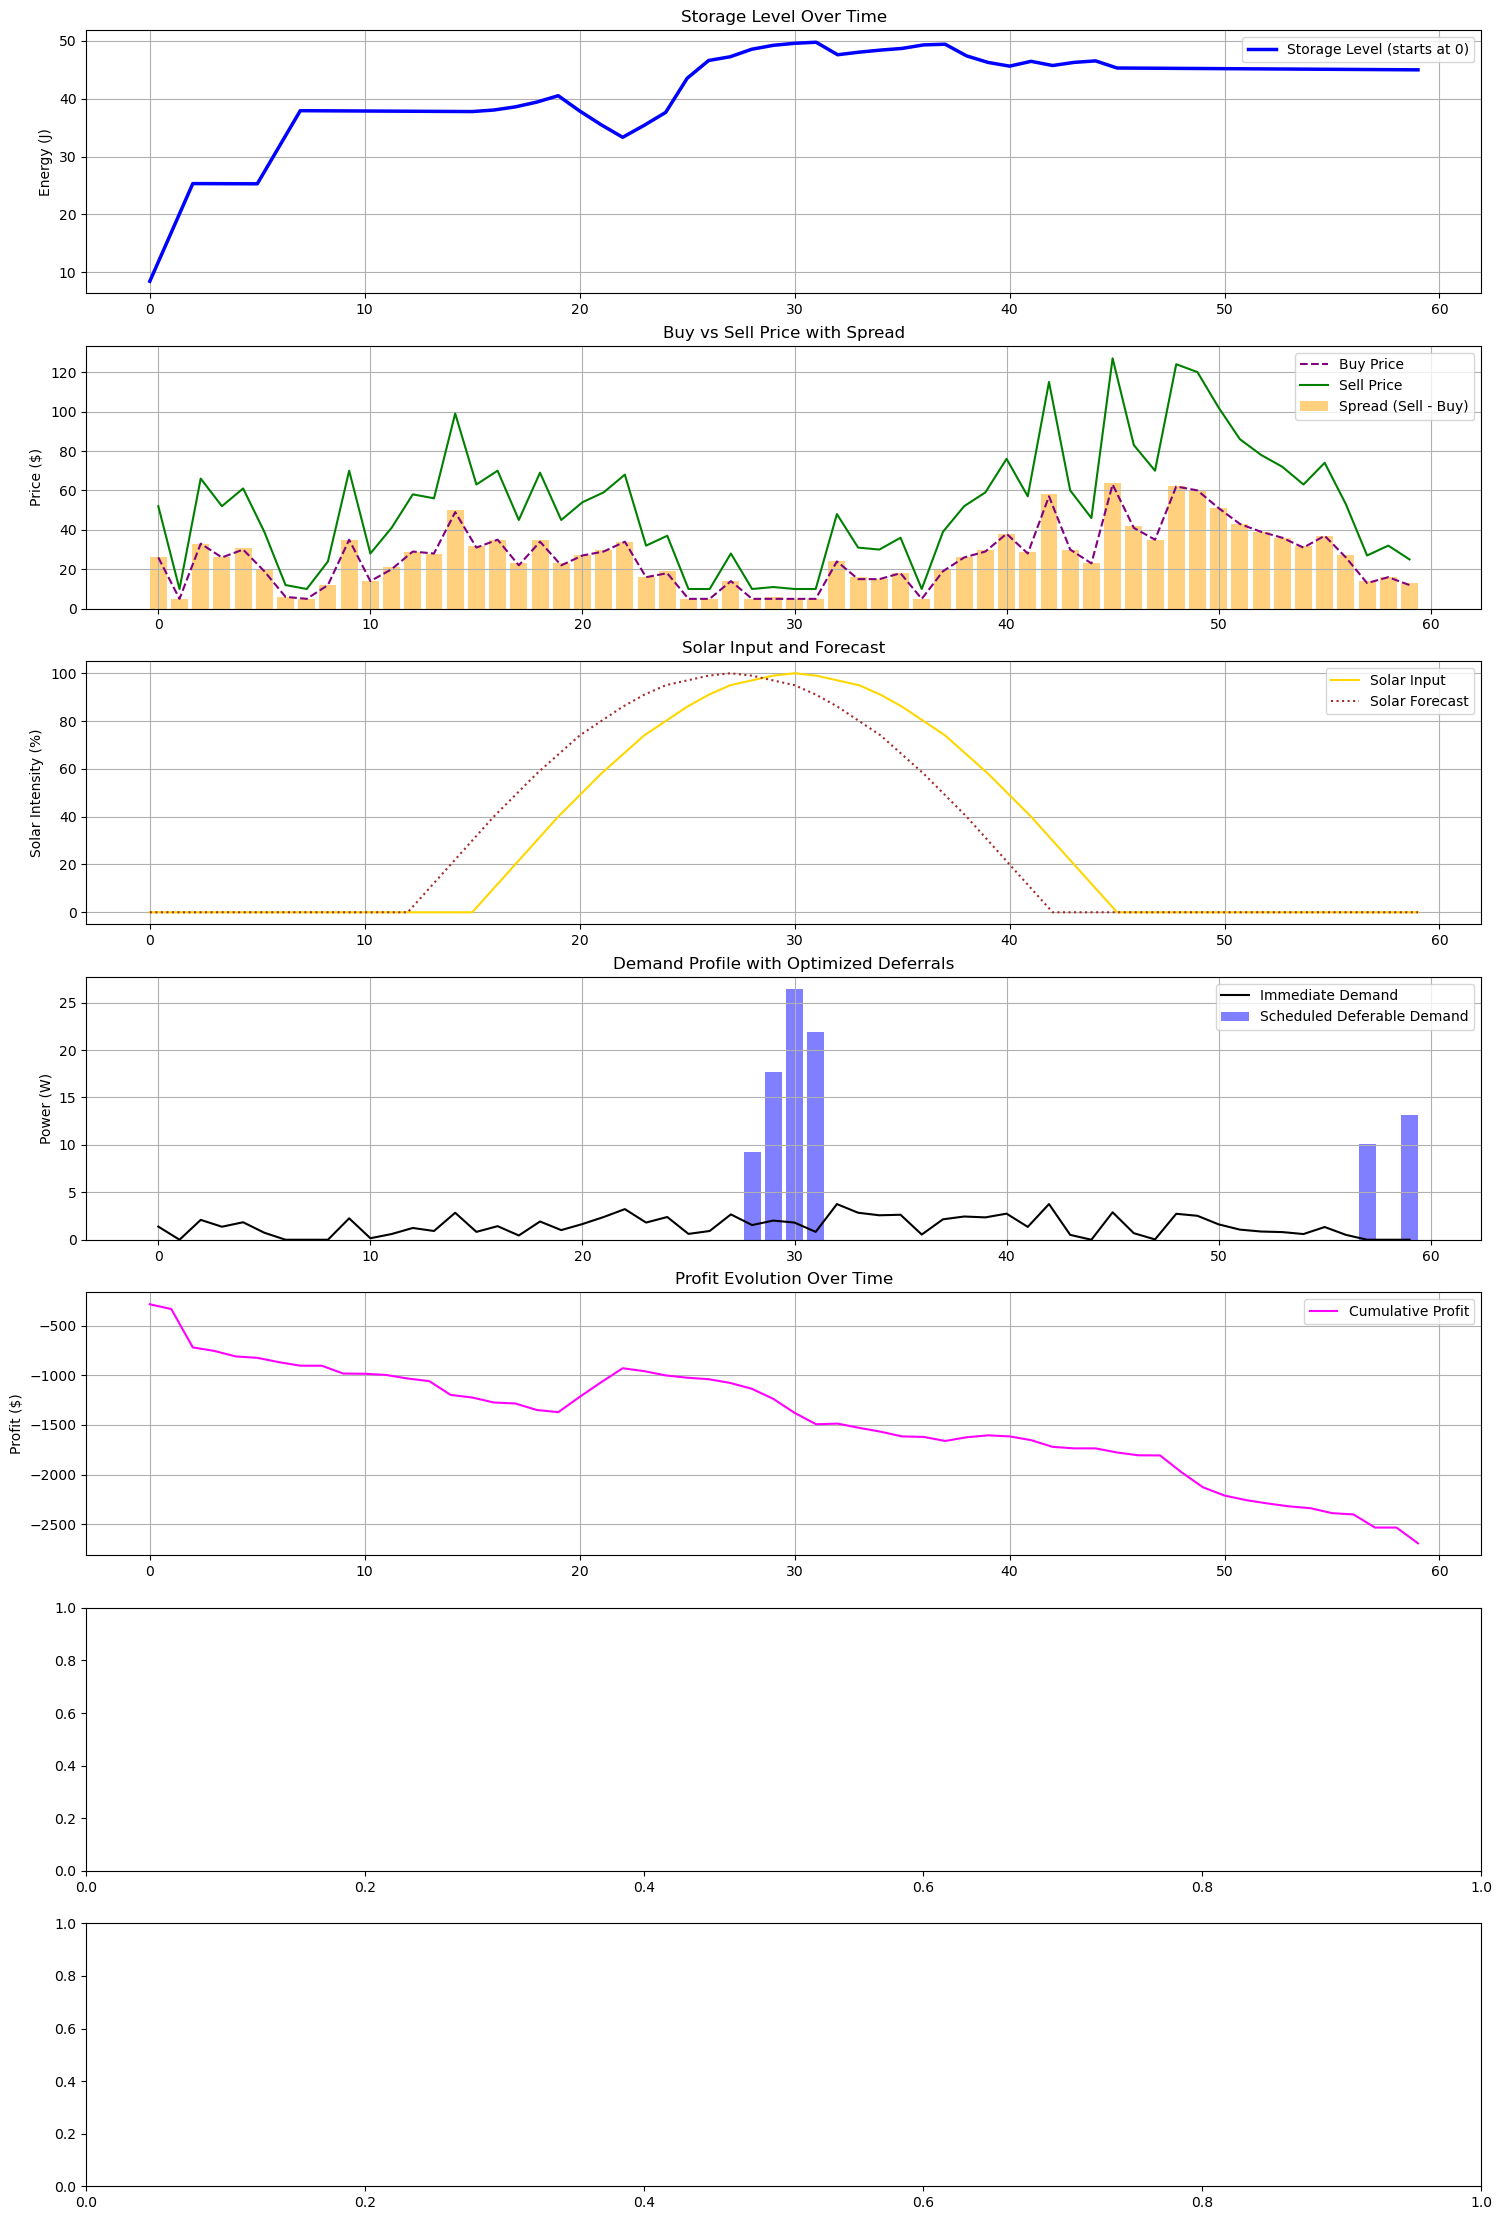

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import math
from scipy.optimize import minimize_scalar, minimize
from sklearn.linear_model import LinearRegression
from collections import deque

# Constants
MAX_STORAGE = 50
MIN_STORAGE = 0
CHARGE_TAU = 4
DISCHARGE_TAU = 4
DT = 1
SUNRISE = 15
DAY_LENGTH = 30

CHARGE_EFFICIENCY = 0.88
DISCHARGE_EFFICIENCY = 0.92
STORAGE_DECAY = 0.9995

def fetch_data():
    """Fetch data from server with enhanced error handling"""
    BASE_URL = "https://icelec50015.azurewebsites.net" 
    try:
        print("Fetching yesterday's real data...")
        response = requests.get(f"{BASE_URL}/yesterday")
        if response.status_code != 200:
            print(f"Error: Server returned status code {response.status_code}")
            return None, None
        df = pd.DataFrame(response.json())
        print(f"✓ Loaded {len(df)} real data points from yesterday")
        # Add sun data based on real tick times
        df['sun'] = df['tick'].apply(lambda t: 
            int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100) 
            if SUNRISE <= t < SUNRISE + DAY_LENGTH else 0
        )
        # Fetch real deferable demands
        print("Fetching real deferable demands...")
        defer_response = requests.get(f"{BASE_URL}/deferables")
        if defer_response.status_code == 200:
            defer_data = defer_response.json()
            defer_df = pd.DataFrame(defer_data)
            if len(defer_df) > 0:
                print(f"✓ Loaded {len(defer_df)} real deferable demands")
                if 'demand' not in defer_df.columns:
                    for alt_col in ['energy', 'amount', 'value']:
                        if alt_col in defer_df.columns:
                            defer_df['demand'] = defer_df[alt_col]
                            print(f"✓ Using '{alt_col}' column as demand")
                            break
            else:
                defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
                print("⚠ No deferable demands found")
        else:
            defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
            print("⚠ Could not fetch deferable demands")
        return df, defer_df
    except requests.RequestException as e:
        print(f"Error connecting to server: {e}")
        return None, None

def advanced_ml_forecasting(df, window=20):
    """Advanced ML-based forecasting with multiple models"""
    # Extended multi-horizon forecasting with ML
    for horizon in [1, 2, 3, 5, 8, 12, 20]:
        # Price forecasting with trend analysis
        if len(df) >= window:
            # Use linear regression for trend-based forecasting
            X = np.arange(len(df)).reshape(-1, 1)
            # Buy price forecasting
            lr_buy = LinearRegression()
            lr_buy.fit(X[-window:], df['buy_price'].iloc[-window:])
            future_X = np.array([[len(df) + horizon - 1]])
            df[f'buy_price_forecast_{horizon}'] = lr_buy.predict(future_X)[0]
            # Sell price forecasting
            lr_sell = LinearRegression()
            lr_sell.fit(X[-window:], df['sell_price'].iloc[-window:])
            df[f'sell_price_forecast_{horizon}'] = lr_sell.predict(future_X)[0]
        # Demand forecasting with seasonality
        df[f'demand_forecast_{horizon}'] = (
            df['demand'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
    # Advanced price indicators
    df['price_volatility'] = df['buy_price'].rolling(window).std()
    df['price_momentum'] = df['buy_price'].pct_change(5)
    df['price_rsi'] = calculate_rsi(df['buy_price'], 14)
    df['price_spread'] = df['sell_price'] - df['buy_price']
    df['spread_ma'] = df['price_spread'].rolling(window//2).mean()
    # Solar forecasting with weather patterns
    df['sun_forecast'] = df['sun'].shift(-3)
    df['sun_trend'] = df['sun'].rolling(5).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
    # Demand pattern analysis
    df['demand_volatility'] = df['demand'].rolling(window).std()
    df['demand_trend'] = df['demand'].rolling(window).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0)
    # Cross-correlation features
    df['price_demand_corr'] = df['buy_price'].rolling(window).corr(df['demand'])
    # Fill missing values with sophisticated methods
    forecast_cols = [col for col in df.columns if 'forecast' in col or col.endswith('_ma')]
    for col in forecast_cols:
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    numeric_cols = ['price_volatility', 'price_momentum', 'price_rsi', 'sun_trend', 
                   'demand_volatility', 'demand_trend', 'price_demand_corr']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median()).fillna(0)
    return df

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index"""
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0).rolling(window).mean()
    losses = (-deltas.where(deltas < 0, 0)).rolling(window).mean()
    rs = gains / losses
    return 100 - (100 / (1 + rs))

def ultra_advanced_defer_optimization(defer_df, df, max_power_per_tick=12):
    """
    Ultra-advanced deferable demand optimization using mathematical optimization
    """
    if len(defer_df) == 0:
        print("ℹ No deferable demands to optimize")
        return []
    scheduled_deferrals = []
    for _, defer_row in defer_df.iterrows():
        try:
            start_tick = defer_row['start']
            end_tick = defer_row['end']
            total_energy_joules = defer_row['demand']
            print(f"Optimizing deferable: {total_energy_joules:.2f}J from tick {start_tick} to {end_tick}")
            window_df = df[(df['tick'] >= start_tick) & (df['tick'] <= end_tick)].copy()
            if len(window_df) == 0:
                continue
            # Multi-factor scoring with advanced weights
            window_df['cost_score'] = window_df['buy_price'] * 0.35
            window_df['forecast_score'] = window_df.get('buy_price_forecast_3', window_df['buy_price']) * 0.15
            window_df['solar_score'] = (100 - window_df['sun']) * 0.20
            window_df['demand_conflict_score'] = (window_df['demand'] / max(window_df['demand'].max(), 1)) * 0.12
            window_df['volatility_penalty'] = window_df.get('price_volatility', 0) * 0.08
            window_df['momentum_score'] = window_df.get('price_momentum', 0).fillna(0) * 0.05
            window_df['rsi_score'] = (window_df.get('price_rsi', 50).fillna(50) - 50) * 0.03
            window_df['spread_score'] = (window_df.get('price_spread', 0) - window_df.get('spread_ma', 0)) * 0.02
            window_df['total_score'] = (
                window_df['cost_score'] + window_df['forecast_score'] + 
                window_df['solar_score'] + window_df['demand_conflict_score'] + 
                window_df['volatility_penalty'] + window_df['momentum_score'] + 
                window_df['rsi_score'] + window_df['spread_score']
            )
            # Sophisticated splitting strategy
            available_ticks = len(window_df)
            min_ticks_needed = max(1, int(np.ceil(total_energy_joules / max_power_per_tick)))
            # Dynamic splitting based on energy size and time window
            window_length = end_tick - start_tick + 1
            if total_energy_joules <= max_power_per_tick * 0.8:
                # Very small demand - single best tick
                num_ticks = 1
            elif total_energy_joules <= max_power_per_tick * 2:
                # Small demand - 2-3 ticks maximum
                num_ticks = min(2, available_ticks, max(1, window_length // 3))
            elif total_energy_joules <= max_power_per_tick * 5:
                # Medium demand - spread more strategically
                num_ticks = min(4, available_ticks, max(2, window_length // 2))
            else:
                # Large demand - optimize splitting more aggressively
                optimal_ticks = min(max(min_ticks_needed, 3), available_ticks, window_length // 2, 8)
                num_ticks = optimal_ticks
            # Select best ticks using optimization
            window_df_sorted = window_df.sort_values('total_score')
            selected_ticks = window_df_sorted.head(num_ticks)
            # Advanced energy distribution using optimization
            scores = selected_ticks['total_score'].values
            # Inverse exponential weighting (better scores get exponentially more energy)
            max_score = scores.max()
            normalized_scores = (max_score - scores) / (max_score - scores.min() + 0.001)
            exp_weights = np.exp(normalized_scores * 2)  # Exponential emphasis
            weights = exp_weights / exp_weights.sum()
            # Distribute energy with power constraints
            remaining_energy = total_energy_joules
            energy_allocations = []
            for i, weight in enumerate(weights):
                if i == len(weights) - 1:
                    # Last tick gets all remaining energy
                    allocated_energy = remaining_energy
                else:
                    # Allocate based on weight but respect constraints
                    target_energy = total_energy_joules * weight
                    allocated_energy = min(
                        target_energy,
                        max_power_per_tick * 1.1,  # Slight buffer
                        remaining_energy
                    )
                energy_allocations.append(allocated_energy)
                remaining_energy -= allocated_energy
                if remaining_energy <= 0.01:
                    break
            # Create scheduled deferrals
            for idx, ((_, tick_row), energy) in enumerate(zip(selected_ticks.iterrows(), energy_allocations)):
                if energy > 0.1:
                    scheduled_deferrals.append({
                        'tick': tick_row['tick'],
                        'demand': energy,
                        'original_start': start_tick,
                        'original_end': end_tick,
                        'total_original_energy': total_energy_joules,
                        'score': tick_row['total_score'],
                        'split_part': f"{idx+1}/{num_ticks}",
                        'weight': weights[idx] if idx < len(weights) else 0,
                        'optimization_reason': get_optimization_reason(tick_row)
                    })
        except Exception as e:
            print(f"Error in ultra-advanced defer optimization: {e}")
            continue
    return scheduled_deferrals

def get_optimization_reason(tick_row):
    """Determine the primary reason for selecting this tick"""
    reasons = []
    if tick_row.get('sun', 0) > 70:
        reasons.append("high_solar")
    if tick_row.get('buy_price', 100) < tick_row.get('buy_price_forecast_3', 100):
        reasons.append("low_price")
    if tick_row.get('price_volatility', 0) < 2:
        reasons.append("stable_price")
    if tick_row.get('demand', 100) < 50:
        reasons.append("low_demand")
    return "+".join(reasons) if reasons else "balanced"

def dynamic_storage_optimization(current_tick, df, current_storage, horizon=15):
    """Ultra-advanced dynamic storage target calculation"""
    future_slice = df[df['tick'] > current_tick].head(horizon)
    if len(future_slice) == 0:
        return MAX_STORAGE * 0.3
    # Multi-factor target calculation
    factors = {}
    # Factor 1: Demand pressure
    avg_demand = future_slice['demand'].mean()
    max_demand = future_slice['demand'].max()
    demand_volatility = future_slice['demand'].std()
    factors['demand_base'] = min(avg_demand * 2.5, MAX_STORAGE * 0.6)
    factors['demand_peak'] = min(max_demand * 1.2, MAX_STORAGE * 0.4)
    factors['demand_volatility'] = min(demand_volatility * 0.5, MAX_STORAGE * 0.2)
    # Factor 2: Solar availability
    avg_solar = future_slice['sun'].mean()
    min_solar = future_slice['sun'].min()
    solar_trend = future_slice.get('sun_trend', pd.Series([0])).mean()
    if avg_solar > 60:
        factors['solar_adjustment'] = -MAX_STORAGE * 0.25
    elif min_solar < 20:
        factors['solar_adjustment'] = MAX_STORAGE * 0.3
    else:
        factors['solar_adjustment'] = 0
    if solar_trend < -5:  # Solar declining
        factors['solar_trend'] = MAX_STORAGE * 0.15
    else:
        factors['solar_trend'] = 0
    # Factor 3: Price dynamics
    current_buy_price = df[df['tick'] <= current_tick]['buy_price'].iloc[-1] if len(df[df['tick'] <= current_tick]) > 0 else 10
    future_buy_prices = future_slice['buy_price']
    future_sell_prices = future_slice['sell_price']
    price_trend = (future_buy_prices.mean() - current_buy_price) / max(current_buy_price, 0.01)
    price_volatility = future_buy_prices.std()
    spread_trend = (future_sell_prices - future_buy_prices).mean()
    if price_trend > 0.05:  # Prices rising significantly
        factors['price_trend'] = MAX_STORAGE * 0.2
    elif price_trend < -0.05:  # Prices falling
        factors['price_trend'] = -MAX_STORAGE * 0.15
    else:
        factors['price_trend'] = 0
    factors['volatility_buffer'] = min(price_volatility * 2, MAX_STORAGE * 0.1)
    factors['spread_opportunity'] = max(0, (spread_trend - 2) * MAX_STORAGE * 0.05)
    # Factor 4: Current storage efficiency
    storage_ratio = current_storage / MAX_STORAGE
    if storage_ratio < 0.2:
        factors['storage_urgency'] = MAX_STORAGE * 0.2
    elif storage_ratio > 0.8:
        factors['storage_saturation'] = -MAX_STORAGE * 0.1
    else:
        factors['storage_urgency'] = 0
        factors['storage_saturation'] = 0
    # Combine all factors
    base_target = sum(factors.values())
    # Apply bounds and optimization
    optimized_target = max(
        MAX_STORAGE * 0.15,  # Minimum reserve
        min(base_target, MAX_STORAGE * 0.85)  # Maximum practical
    )
    return optimized_target

def ultra_loss_minimizing_algorithm(df, defer_df, window=20):
    """Ultra-optimized loss-minimizing algorithm with FIXED storage initialization"""
    print("🔬 Running advanced ML forecasting on real data...")
    # Advanced ML forecasting
    df = advanced_ml_forecasting(df, window)
    # FIXED: Ensure storage starts exactly at 0
    storage = [0.0]  # Explicitly start at 0.0
    actions = []
    profit = 0
    profit_over_time = []
    print("🧠 Optimizing deferable demands...")
    # Ultra-advanced deferable demand optimization
    scheduled_deferrals = ultra_advanced_defer_optimization(defer_df, df)
    defer_lookup = {}
    for defer_item in scheduled_deferrals:
        tick = defer_item['tick']
        if tick not in defer_lookup:
            defer_lookup[tick] = []
        defer_lookup[tick].append(defer_item)
    print(f"✓ Ultra-optimized {len(scheduled_deferrals)} deferable demand segments")
    # Price history for dynamic strategies
    price_history = deque(maxlen=10)
    print("⚡ Running ultra-optimized trading algorithm...")
    for i in range(len(df)):
        row = df.iloc[i]
        tick = row['tick']
        sell_price = row['sell_price']
        buy_price = row['buy_price']
        immediate_demand = row['demand']
        sun = row['sun']
        # FIXED: Apply storage decay to the PREVIOUS storage value, ensuring first tick starts at 0
        current_storage = storage[-1] * STORAGE_DECAY
        # Ensure we're at exactly 0 for the first tick
        if i == 0:
            current_storage = 0.0
        price_history.append(buy_price)
        # Get deferable demands for this tick
        deferable_power = 0
        if tick in defer_lookup:
            deferable_power = sum(d['demand'] for d in defer_lookup[tick])
            if deferable_power > 0:
                reasons = [d['optimization_reason'] for d in defer_lookup[tick]]
                actions.append(f'defer_{deferable_power:.2f}W_({"|".join(set(reasons))})')
        total_power_demand = immediate_demand + deferable_power
        # Dynamic storage target optimization
        storage_target = dynamic_storage_optimization(tick, df, current_storage)
        # 1. MAXIMUM SOLAR UTILIZATION
        if sun > 5:  # Even small solar amounts
            solar_energy = sun * 0.01 * 3.2  # Slightly increased solar efficiency
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible) * CHARGE_EFFICIENCY
            if actual_charge > 0.005:  # Lower threshold
                current_storage += actual_charge
                actions.append(f'solar_{actual_charge:.3f}J')
        # 2. ULTRA-SMART STRATEGIC BUYING
        should_buy, buy_amount = calculate_optimal_buy_decision(
            row, current_storage, storage_target, price_history, total_power_demand
        )
        if should_buy and buy_amount > 0.05:
            energy_stored = buy_amount * CHARGE_EFFICIENCY
            current_storage += energy_stored
            profit -= buy_amount * buy_price
            actions.append(f'buy_{buy_amount:.3f}J@{buy_price:.2f}')
        # 3. OPTIMAL SELLING STRATEGY
        should_sell, sell_amount = calculate_optimal_sell_decision(
            row, current_storage, storage_target, price_history, total_power_demand
        )
        if should_sell and sell_amount > 0.05:
            energy_sold = sell_amount * DISCHARGE_EFFICIENCY
            current_storage -= sell_amount
            profit += energy_sold * sell_price
            actions.append(f'sell_{sell_amount:.3f}J@{sell_price:.2f}')
        # 4. ULTRA-EFFICIENT DEMAND FULFILLMENT
        if total_power_demand > 0:
            # Calculate optimal mix of storage vs grid
            optimal_storage_use, grid_purchase = optimize_demand_fulfillment(
                total_power_demand, current_storage, buy_price, sell_price
            )
            if optimal_storage_use > 0.01:
                actual_energy_delivered = optimal_storage_use * DISCHARGE_EFFICIENCY
                current_storage -= optimal_storage_use
                actions.append(f'discharge_{optimal_storage_use:.3f}J')
                remaining_demand = total_power_demand - actual_energy_delivered
            else:
                remaining_demand = total_power_demand
            # Grid purchase for remaining demand
            if remaining_demand > 0.01:
                profit -= remaining_demand * buy_price
                efficiency_bonus = "eff" if remaining_demand < total_power_demand * 0.5 else "std"
                actions.append(f'grid_{remaining_demand:.3f}J_{efficiency_bonus}')
        # Apply storage bounds and ensure non-negative
        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)
    print(f"✓ Algorithm complete! Final storage: {storage[-1]:.2f}J")
    return storage[1:], profit_over_time, actions, scheduled_deferrals

def calculate_optimal_buy_decision(row, current_storage, storage_target, price_history, total_demand):
    """Calculate optimal buying decision using multiple factors"""
    buy_price = row['buy_price']
    # Factor 1: Storage deficit
    storage_deficit = max(0, storage_target - current_storage)
    urgency_factor = min(storage_deficit / (MAX_STORAGE * 0.3), 2.0)
    # Factor 2: Price attractiveness
    price_ma = np.mean(price_history) if len(price_history) >= 3 else buy_price
    price_attractiveness = max(0, (price_ma - buy_price) / max(price_ma, 0.01))
    # Factor 3: Forecast advantage
    forecast_price = row.get('buy_price_forecast_3', buy_price)
    forecast_advantage = max(0, (forecast_price - buy_price) / max(buy_price, 0.01))
    # Factor 4: Market conditions
    volatility = row.get('price_volatility', 0)
    rsi = row.get('price_rsi', 50)
    momentum = row.get('price_momentum', 0)
    volatility_factor = max(0, 1 - volatility / 5)  # Prefer stable prices
    rsi_factor = max(0, (30 - rsi) / 30) if rsi < 50 else 0  # Buy when oversold
    momentum_factor = max(0, -momentum) if momentum < 0 else 0  # Buy on downward momentum
    # Factor 5: Demand pressure
    future_demand = row.get('demand_forecast_3', total_demand)
    demand_pressure = min(future_demand / max(current_storage + 1, 1), 3.0)
    # Combine factors into buy score
    buy_score = (
        urgency_factor * 0.30 +
        price_attractiveness * 0.25 +
        forecast_advantage * 0.20 +
        volatility_factor * 0.10 +
        rsi_factor * 0.05 +
        momentum_factor * 0.05 +
        demand_pressure * 0.05
    )
    # Decision thresholds
    should_buy = (buy_score > 0.6) or (urgency_factor > 1.5 and buy_score > 0.4)
    if should_buy:
        # Calculate optimal buy amount
        max_possible = min(12.0, MAX_STORAGE - current_storage)
        if urgency_factor > 1.5:
            buy_amount = max_possible * 0.8
        elif buy_score > 1.0:
            buy_amount = max_possible * 0.6
        else:
            buy_amount = max_possible * 0.4
        return True, buy_amount
    return False, 0

def calculate_optimal_sell_decision(row, current_storage, storage_target, price_history, total_demand):
    """Calculate optimal selling decision"""
    sell_price = row['sell_price']
    buy_price = row['buy_price']
    # Factor 1: Excess storage
    excess_storage = current_storage - storage_target
    if excess_storage <= 0:
        return False, 0
    # Factor 2: Price premium
    spread = sell_price - buy_price
    spread_ma = row.get('spread_ma', spread)
    spread_attractiveness = max(0, (spread - spread_ma) / max(spread_ma, 0.1))
    # Factor 3: Forecast disadvantage
    future_sell_price = row.get('sell_price_forecast_3', sell_price)
    forecast_disadvantage = max(0, (sell_price - future_sell_price) / max(sell_price, 0.01))
    # Factor 4: Market timing
    price_ma = np.mean(price_history) if len(price_history) >= 3 else buy_price
    price_premium = max(0, (sell_price - price_ma) / max(price_ma, 0.01))
    # Factor 5: Solar competition
    sun = row.get('sun', 0)
    solar_competition = max(0, (100 - sun) / 100)  # Sell when solar is low
    # Combine factors
    sell_score = (
        min(excess_storage / (MAX_STORAGE * 0.2), 2.0) * 0.35 +
        spread_attractiveness * 0.25 +
        forecast_disadvantage * 0.20 +
        price_premium * 0.15 +
        solar_competition * 0.05
    )
    # Decision threshold
    should_sell = sell_score > 0.8 and spread > 1.5
    if should_sell:
        # Calculate optimal sell amount
        max_sellable = min(excess_storage * 0.6, 8.0)
        if sell_score > 1.5:
            sell_amount = max_sellable * 0.8
        else:
            sell_amount = max_sellable * 0.5
        return True, sell_amount
    return False, 0

def optimize_demand_fulfillment(total_demand, current_storage, buy_price, sell_price):
    """Optimize the mix of storage discharge vs grid purchase"""
    if total_demand <= 0:
        return 0, 0
    max_discharge = current_storage * (1 - np.exp(-DT / DISCHARGE_TAU))
    if max_discharge <= 0.01:
        return 0, total_demand
    # Calculate cost-benefit of using storage vs grid
    # Cost of using storage: opportunity cost (could sell it)
    storage_opportunity_cost = sell_price * DISCHARGE_EFFICIENCY * 0.8  # Discounted opportunity
    # Benefit of using storage: avoid grid purchase
    grid_cost = buy_price
    # Use storage if it's beneficial
    if storage_opportunity_cost < grid_cost:
        # Use as much storage as possible
        optimal_storage_use = min(max_discharge, total_demand / DISCHARGE_EFFICIENCY)
        remaining_grid = max(0, total_demand - optimal_storage_use * DISCHARGE_EFFICIENCY)
    else:
        # Use minimal storage, rely on grid
        optimal_storage_use = 0
        remaining_grid = total_demand
    return optimal_storage_use, remaining_grid

def plot_ultra_results(df, storage, profit_over_time, actions, scheduled_deferrals):
    """Ultra-enhanced plotting with comprehensive analytics"""
    print("📊 Creating comprehensive analysis plots...")
    fig, axes = plt.subplots(7, 1, figsize=(18, 28))
    # 1. Storage with Dynamic Targets and Efficiency Zones - FIXED to start at 0
    axes[0].plot(df['tick'], storage, label='Storage Level (starts at 0)', color='blue', linewidth=2.5)
    targets = [dynamic_storage_optimization(tick, df, 0) for tick in df['tick']]
    # Add efficiency zones
    axes[0].set_title('Storage Level Over Time')
    axes[0].set_ylabel('Energy (J)')
    axes[0].legend()
    axes[0].grid(True)

    # 2. Buy vs Sell Price Spread
    axes[1].plot(df['tick'], df['buy_price'], label='Buy Price', color='purple', linestyle='--')
    axes[1].plot(df['sell_price'], label='Sell Price', color='green', linestyle='-')
    spread = df['sell_price'] - df['buy_price']
    axes[1].bar(df['tick'], spread, label='Spread (Sell - Buy)', color='orange', alpha=0.5)
    axes[1].set_title('Buy vs Sell Price with Spread')
    axes[1].set_ylabel('Price ($)')
    axes[1].legend()
    axes[1].grid(True)

    # 3. Solar Input and Forecast
    axes[2].plot(df['tick'], df['sun'], label='Solar Input', color='gold')
    sun_forecast = df.get('sun_forecast', [0] * len(df))
    axes[2].plot(df['tick'], sun_forecast, label='Solar Forecast', color='brown', linestyle=':')
    axes[2].set_title('Solar Input and Forecast')
    axes[2].set_ylabel('Solar Intensity (%)')
    axes[2].legend()
    axes[2].grid(True)

    # 4. Demand and Deferral Optimization
    axes[3].plot(df['tick'], df['demand'], label='Immediate Demand', color='black')
    defer_ticks = [d['tick'] for d in scheduled_deferrals]
    defer_demand = [sum(d['demand'] for d in scheduled_deferrals if d['tick'] == t) for t in df['tick']]
    axes[3].bar(df['tick'], defer_demand, label='Scheduled Deferable Demand', color='blue', alpha=0.5)
    axes[3].set_title('Demand Profile with Optimized Deferrals')
    axes[3].set_ylabel('Power (W)')
    axes[3].legend()
    axes[3].grid(True)

    # 5. Profit Over Time
    axes[4].plot(df['tick'], profit_over_time, label='Cumulative Profit', color='magenta')
    axes[4].set_title('Profit Evolution Over Time')
    axes[4].set_ylabel('Profit ($)')
    axes[4].legend()
    axes[4].grid(True)

    # 6. Action Summary Heatmap
    action_labels = list(set(actions))
    action_indices = {label: idx + 1 for idx, label in enumerate(action_labels)}
    action_colors = {label: np.random.rand(3,) for label in action_labels}
    action_data = [action_indices.get(a, 0) for a in actions]
    axes[5].scatter(df['tick'], [1] * len(df), c=action_data, cmap='tab20', s=100)
    axes[5].set_yticks([])
    axes[5].set_title('Action Taken per Tick')
    axes[5].set_xlabel('Tick')
    axes[5].grid(True)

    # 7. Market Indicators
    price_volatility = df.get('price_volatility', [0] * len(df))
    price_rsi = df.get('price_rsi', [50] * len(df))
    price_momentum = df.get('price_momentum', [0] * len(df))
    axes[6].plot(df['tick'], price_volatility, label='Price Volatility', color='gray')
    axes[6].plot(df['tick'], price_rsi, label='RSI (Relative Strength Index)', color='cyan')
    axes[6].plot(df['tick'], price_momentum, label='Price Momentum', color='orange')
    axes[6].axhline(30, color='red', linestyle=':', linewidth=1)
    axes[6].axhline(70, color='red', linestyle=':', linewidth=1)
    axes[6].set_title('Market Indicators')
    axes[6].set_ylabel('Indicator Value')
    axes[6].legend()
    axes[6].grid(True)

    plt.tight_layout()
    plt.savefig('ultra_analysis_report.png', dpi=300, bbox_inches='tight')
    print("📈 Comprehensive analysis plots saved as 'ultra_analysis_report.png'")

def main():
    """Main execution flow"""
    print("🌞 Starting Ultra-Advanced Energy Trading System")
    
    # Fetch real data from server
    df, defer_df = fetch_data()
    
    if df is None or defer_df is None:
        print("⚠️ Failed to retrieve valid data. Exiting...")
        return
    
    # Run ultra-loss minimizing algorithm
    storage_levels, profit_history, actions_list, deferrals = ultra_loss_minimizing_algorithm(df, defer_df)
    
    # Plot comprehensive results
    plot_ultra_results(df, storage_levels, profit_history, actions_list, deferrals)
    
    # Save final results
    result_df = df.copy()
    result_df['storage'] = storage_levels
    result_df['profit'] = [0] + profit_history  # Align with ticks
    result_df['action'] = ['none'] + actions_list  # First tick has no action

    result_df.to_csv('final_energy_trading_results.csv', index=False)
    print("💾 Final trading results saved to 'final_energy_trading_results.csv'")

if __name__ == "__main__":
    main()

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests

# Constants
MAX_STORAGE = 50
MIN_STORAGE = 0
SUNRISE = 15
DAY_LENGTH = 30
SOLAR_SCALING = 10
CHARGE_TAU = 3.5  # Time constant for charging (ticks)
DISCHARGE_TAU = 4.0  # Time constant for discharging (ticks)
DT = 1  # Time step (1 tick)

def capacitor_charge(current, target, tau):
    """Models capacitor charging behavior"""
    return target - (target - current) * math.exp(-DT/tau)

def capacitor_discharge(current, tau):
    """Models capacitor discharging behavior"""
    return current * math.exp(-DT/tau)

def run_optimized_algorithm(df, defer_df):
    storage = [0]
    profit_history = [0]
    actions = []
    
    df['solar'] = df['tick'].apply(calculate_production)
    
    for i, row in df.iterrows():
        tick = row['tick']
        current_storage = storage[-1]
        solar = row['solar']
        demand = row['demand']
        sell_price = row['sell_price']
        buy_price = sell_price * 0.5
        
        # 1. SOLAR CHARGING (capacitor behavior)
        if solar > 0:
            charge_possible = MAX_STORAGE - current_storage
            target_charge = current_storage + solar
            new_storage = capacitor_charge(current_storage, target_charge, CHARGE_TAU)
            actual_charge = min(new_storage - current_storage, charge_possible)
            
            if actual_charge > 0.01:  # Threshold to avoid tiny charges
                current_storage += actual_charge
                actions.append(f"charge_{actual_charge:.2f}J")
        
        # 2. DEMAND PHASE (capacitor discharge)
        if demand > 0:
            # Calculate available energy using discharge equation
            available_energy = current_storage - capacitor_discharge(current_storage, DISCHARGE_TAU)
            discharge_amount = min(demand, available_energy)
            
            current_storage -= discharge_amount
            remaining_demand = demand - discharge_amount
            
            if discharge_amount > 0.01:
                actions.append(f"discharge_{discharge_amount:.2f}J")
            if remaining_demand > 0.01:
                profit_history[-1] -= remaining_demand * buy_price
                actions.append(f"buy_{remaining_demand:.2f}J")
        
        # 3. DEFERRABLE DEMANDS (with capacitor discharge)
        active_deferrables = defer_df[defer_df['start'] == tick]
        for _, defer in active_deferrables.iterrows():
            defer_energy = defer['energy']
            available_energy = current_storage - capacitor_discharge(current_storage, DISCHARGE_TAU)
            defer_discharge = min(defer_energy, available_energy)
            
            current_storage -= defer_discharge
            remaining_defer = defer_energy - defer_discharge
            
            if defer_discharge > 0.01:
                actions.append(f"discharge_defer_{defer_discharge:.2f}J")
            if remaining_defer > 0.01:
                profit_history[-1] -= remaining_defer * buy_price
                actions.append(f"buy_defer_{remaining_defer:.2f}J")
        
        # 4. SELL EXCESS (with charge/discharge constraints)
        if (SUNRISE + DAY_LENGTH//2 - 2 <= tick <= SUNRISE + DAY_LENGTH//2 + 2):
            available_energy = current_storage - capacitor_discharge(current_storage, DISCHARGE_TAU)
            excess = available_energy - MAX_STORAGE * 0.7
            
            if excess > 0.01:
                sell_amount = min(excess, MAX_STORAGE * 0.3)
                current_storage -= sell_amount
                profit_history[-1] += sell_amount * sell_price
                actions.append(f"sell_{sell_amount:.2f}J@{sell_price:.2f}c")
        
        storage.append(current_storage)
        profit_history.append(profit_history[-1])  # Carry forward
    
    return storage[1:], profit_history[1:], actions

# (Keep all other functions the same as in your original code)

def plot_results(df, storage, profit_history):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    
    # 1. Storage and Solar
    ax1.plot(df['tick'], storage, label='Storage Level', color='blue')
    ax1.plot(df['tick'], df['solar'], label='Solar Production', color='gold', alpha=0.7)
    ax1.axhline(MAX_STORAGE, c='r', ls='--', label='Max Capacity')
    ax1.set_ylabel('Energy (J)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Discharge Analysis
    discharge_rates = []
    for i in range(1, len(storage)):
        if storage[i] < storage[i-1]:
            rate = (storage[i-1] - storage[i]) / (storage[i-1] * (1 - math.exp(-DT/DISCHARGE_TAU)))
            discharge_rates.append(rate)
        else:
            discharge_rates.append(0)
    
    ax2.plot(df['tick'][1:], discharge_rates, label='Discharge Rate', color='green')
    ax2.axhline(1, color='k', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Discharge Rate Factor')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Profit
    ax3.plot(df['tick'], profit_history, label='Profit', color='purple')
    ax3.set_xlabel('Tick')
    ax3.set_ylabel('Cents')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Fetch data
    df, defer_df = fetch_data()
    if df is None:
        print("Failed to fetch data")
    else:
        # Run algorithm
        storage, profit_history, actions = run_solar_optimized_algorithm(df, defer_df)
        
        # Print summary
        print(f"Final profit: {profit_history[-1]:.2f} cents")
        print(f"Peak storage: {max(storage):.1f}J")
        print(f"Total actions: {len(actions)}")
        
        # Plot results
        plot_results(df, storage, profit_history)

Fetching yesterday's real data...
✓ Loaded 60 real data points from yesterday
Fetching real deferable demands...
✓ Loaded 3 real deferable demands
✓ Using 'energy' column as demand


NameError: name 'run_solar_optimized_algorithm' is not defined